<a href="https://colab.research.google.com/github/Theresa20191/Theresa/blob/main/UTM/Lab%20Exercise/Lab_2B_Big_Data_EDA_Theresa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of 7+ million company dataset

##Name: Lee Seow Ming Theresa
##Matric no.: MCS231013

## Objective

* What can we learn about business names?
* How can we use these insights?

## Imports

In [3]:
!pip install mapclassify
!pip install -q kaggle
from google.colab import files

# Upload the Kaggle API key
uploaded = files.upload()

# create a kaggle folder
!mkdir -p ~/.kaggle

# copy kaggle.json to the folder created
!cp kaggle.json ~/.kaggle/

# Persimission for json to act
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d peopledatalabssf/free-7-million-company-dataset

!unzip -q /content/free-7-million-company-dataset.zip


Saving kaggle.json to kaggle.json
 99% 277M/278M [00:02<00:00, 140MB/s]
100% 278M/278M [00:02<00:00, 130MB/s]


In [4]:
pip install geotext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00


In [5]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geotext
import collections
import string, sys, os, re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image
from functools import reduce
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

## Helper functions and classes

In [7]:
class DfOverview:
    """
        Give an overview for a given data frame,
        like null persentage for each columns,
        unique value percentage for each columns and more
    """

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def missing_value(self) -> None:
        nullSum = self.df.isna().sum()
        return [col for col in nullSum]

    def percentage(self, list):
        return [str(round(((value / self.df.shape[0]) * 100), 2)) + '%' for value in list]

    def getOverview(self) -> None:

        _columns = [column for column in self.df]
        _count = self.df.count().values
        _unique = [self.df[column].value_counts().shape[0] for column in self.df]
        _missing_values = self.missing_value()

        columns = [
            'Column',
            'count',
            'missing_value_count',
            'Missing_value_percentage',
            'unique_value_count',
            'unique_value_percentage',
            'dtype']
        data = zip(
            _columns,
            _count,
            _missing_values,
            self.percentage(_missing_values),
            _unique,
            self.percentage(_unique),
            self.df.dtypes
        )
        new_df = pd.DataFrame(data=data, columns=columns)
        return new_df

In [8]:
def show_cols_mixed_dtypes(df):
    mixed_dtypes = {'Column': [], 'Data type': []}
    for col in df.columns:
        dtype = pd.api.types.infer_dtype(df[col])
        if dtype.startswith("mixed"):
            mixed_dtypes['Column'].append(col)
            mixed_dtypes['Data type'].append(dtype)
    if len(mixed_dtypes['Column']) == 0:
        print('None of the columns contain mixed types.')
    else:
        print(pd.DataFrame(mixed_dtypes))

In [9]:
def percent_missing_values(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

In [10]:
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * mis_val / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending and remove columns with no missing values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,0] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    if mis_val_table_ren_columns.shape[0] == 0:
        return

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [11]:
def convert_to_string(df, columns):
    for col in columns:
        df[col] = df[col].astype("string")

In [12]:
def drop_duplicates(df):
    old = df.shape[0]
    df.drop_duplicates(inplace=True)
    new = df.shape[0]
    count = old - new
    if (count == 0):
        print("No duplicate rows were found.")
    else:
        print(f"{count} duplicate rows were found and removed.")

def plot_dist(df:pd.DataFrame, column:str, color:str='cornflowerblue')->None:
    sns.displot(data=df, x=column, color=color,  kde=False, height=6, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plotly_plot_bar(df, x, y, title=None, width=800, color=['cornflowerblue']):
    if title == None:
        title=f'Distribution of {x}'
    fig = px.bar(df, x=x, y=y, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

def plotly_plot_pie(df, column, title=None, width=800, limit=None):
    a = pd.DataFrame({'count': df.groupby([column]).size()}).reset_index()
    a = a.sort_values("count", ascending=False)
    if limit:
        a.loc[a['count'] < limit, column] = f'Other {column}s'
    if title == None:
        title=f'Distribution of {column}'
    fig = px.pie(a, values='count', names=column, title=title)
    return Image(pio.to_image(fig, format='png', width=width))

## Data Reading

In [13]:
# reading the companies_sorted csv file
df = pd.read_csv("/content/companies_sorted.csv")
df

Unnamed: 0                            name  \
0           5872184                             ibm   
1           4425416       tata consultancy services   
2             21074                       accenture   
3           2309813                         us army   
4           1558607                              ey   
...             ...                             ...   
7173421     1494427              certiport vouchers   
7173422     1494429          black tiger fight club   
7173423     4768462      catholic bishop of chicago   
7173424     1494436             medexo robotics ltd   
7173425     2842728  dynamic controls solutions inc   

                               domain  year founded  \
0                             ibm.com        1911.0   
1                             tcs.com        1968.0   
2                       accenture.com        1989.0   
3                          goarmy.com        1800.0   
4                              ey.com        1989.0   
...                               ...           ...   
7173421         certiportvouchers.com        2011.0   
7173422            blacktigerclub.com        2006.0   
7173423                           NaN           NaN   
7173424                           NaN           NaN   
7173425  dynamiccontrolssolutions.com           NaN   

                                    industry size range  \
0        information technology and services     10001+   
1        information technology and services     10001+   
2        information technology and services     10001+   
3                                   military     10001+   
4                                 accounting     10001+   
...                                      ...        ...   
7173421  information technology and services     1 - 10   
7173422         health, wellness and fitness     1 - 10   
7173423               religious institutions     1 - 10   
7173424                             research     1 - 10   
7173425                           automotive     1 - 10   

                                       locality         country  \
0             new york, new york, united states   united states   
1                    bombay, maharashtra, india           india   
2                       dublin, dublin, ireland         ireland   
3           alexandria, virginia, united states   united states   
4        london, greater london, united kingdom  united kingdom   
...                                         ...             ...   
7173421                                     NaN             NaN   
7173422                  peking, beijing, china           china   
7173423      inverness, illinois, united states   united states   
7173424          london, london, united kingdom  united kingdom   
7173425          wixom, michigan, united states   united states   

                                              linkedin url  \
0                                 linkedin.com/company/ibm   
1           linkedin.com/company/tata-consultancy-services   
2                           linkedin.com/company/accenture   
3                             linkedin.com/company/us-army   
4                       linkedin.com/company/ernstandyoung   
...                                                    ...   
7173421            linkedin.com/company/certiport-vouchers   
7173422         linkedin.com/company/black-tiger-club-hero   
7173423    linkedin.com/company/catholic-bishop-of-chicago   
7173424           linkedin.com/company/medexo-robotics-ltd   
7173425  linkedin.com/company/dynamic-controls-solution...   

         current employee estimate  total employee estimate  
0                           274047                   716906  
1                           190771                   341369  
2                           190689                   455768  
3                           162163                   445958  
4                           158363                   428960  
...                            ...                      

## General Statistics

In [14]:
# number of elements(cells) in the df
df.size

78907686

In [15]:
# rows and columns in the df
df.shape

(7173426, 11)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


In [17]:
df_overview = DfOverview(df)
df_overview.getOverview()

Column    count  missing_value_count  \
0                  Unnamed: 0  7173426                    0   
1                        name  7173423                    3   
2                      domain  5522805              1650621   
3                year founded  3566446              3606980   
4                    industry  6883423               290003   
5                  size range  7173426                    0   
6                    locality  4664601              2508825   
7                     country  4824219              2349207   
8                linkedin url  7173426                    0   
9   current employee estimate  7173426                    0   
10    total employee estimate  7173426                    0   

   Missing_value_percentage  unique_value_count unique_value_percentage  \
0                      0.0%             7173426                  100.0%   
1                      0.0%             7004634                  97.65%   
2                    23.01%             5474764                  76.32%   
3                    50.28%                 234                    0.0%   
4                     4.04%                 148                    0.0%   
5                      0.0%                   8                    0.0%   
6                    34.97%               96244                   1.34%   
7                    32.75%                 236                    0.0%   
8                      0.0%             7173426                  100.0%   
9                      0.0%                5379                   0.07%   
10                     0.0%                8486                   0.12%   

      dtype  
0     int64  
1    object  
2    object  
3   float64  
4    object  
5    object  
6    object  
7    object  
8    object  
9     int64  
10    int64

Here we can see detailed informations of the columns including the amount missing and unique values.

## Dropping unnecessary Columns
The column 'Unamed: 0' most of the times represents the index when we save our dataframe to csv along with our index. In this is the case, since each index is unique and not actually related to each row, removing it is advisable. Let us check its uniqueness.

In [18]:
# comparing the number of unique values of 'Unnamed: 0' and the number of rows
len(df['Unnamed: 0'].unique()) == df.shape[0]

True

Since my assumption is correct, I will remove the column.

In [19]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Missing Values

In [20]:
percent_missing_values(df)

The dataset contains 14.51 % missing values.


In [21]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3606980              50.28  float64
locality             2508825              34.97   object
country              2349207              32.75   object
domain               1650621              23.01   object
industry              290003               4.04   object
name                       3               0.00   object

From the missing table we can see that there are 6 columns with missing values. But name and industry are very necessary. So we will remove rows with null values in these columns.

In [22]:
df.drop(df.index[df.name.isna()], inplace=True)
df.drop(df.index[df.industry.isna()], inplace=True)
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 4 columns that have missing values.


Missing Values  % of Total Values    Dtype
year founded         3317945              48.20  float64
locality             2304053              33.47   object
country              2148684              31.22   object
domain               1473392              21.40   object

## Data Types
Let's check if there are columns with mixed data types.

In [23]:
show_cols_mixed_dtypes(df)

None of the columns contain mixed types.


In [24]:
df.dtypes

name                          object
domain                        object
year founded                 float64
industry                      object
size range                    object
locality                      object
country                       object
linkedin url                  object
current employee estimate      int64
total employee estimate        int64
dtype: object

In [25]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com        1911.0   
1  tata consultancy services        tcs.com        1968.0   
2                  accenture  accenture.com        1989.0   
3                    us army     goarmy.com        1800.0   
4                         ey         ey.com        1989.0   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

As we can see from above 'name', 'domain', 'industry', 'size range', 'locality', 'country' and 'linkedin url' hold string values. In addition to this we also know that 'year founded' should hold integer values. Therefore, we will convert these columns to their respective correct data types.

In [26]:
# get the columns with object data type
string_columns = df.select_dtypes(include='object').columns.tolist()
string_columns

['name',
 'domain',
 'industry',
 'size range',
 'locality',
 'country',
 'linkedin url']

In [27]:
convert_to_string(df, string_columns)

In order to convert 'year founded', we have to replace NaN values with 0 so that pandas will not raise an error saying "Cannot convert non-finite values (NA or inf) to integer".

In [28]:
df['year founded'].fillna(0, inplace=True)
df['year founded'] = df['year founded'].astype('int64')

In [29]:
df.dtypes

name                         string
domain                       string
year founded                  int64
industry                     string
size range                   string
locality                     string
country                      string
linkedin url                 string
current employee estimate     int64
total employee estimate       int64
dtype: object

In [30]:
df.head()

name         domain  year founded  \
0                        ibm        ibm.com          1911   
1  tata consultancy services        tcs.com          1968   
2                  accenture  accenture.com          1989   
3                    us army     goarmy.com          1800   
4                         ey         ey.com          1989   

                              industry size range  \
0  information technology and services     10001+   
1  information technology and services     10001+   
2  information technology and services     10001+   
3                             military     10001+   
4                           accounting     10001+   

                                 locality         country  \
0       new york, new york, united states   united states   
1              bombay, maharashtra, india           india   
2                 dublin, dublin, ireland         ireland   
3     alexandria, virginia, united states   united states   
4  london, greater london, united kingdom  united kingdom   

                                     linkedin url  current employee estimate  \
0                        linkedin.com/company/ibm                     274047   
1  linkedin.com/company/tata-consultancy-services                     190771   
2                  linkedin.com/company/accenture                     190689   
3                    linkedin.com/company/us-army                     162163   
4              linkedin.com/company/ernstandyoung                     158363   

   total employee estimate  
0                   716906  
1                   341369  
2                   455768  
3                   445958  
4                   428960

Now every data type looks good.

## Duplicates

In [31]:
# search for duplicate rows and drop them
drop_duplicates(df)

No duplicate rows were found.


Since name is the feature that uniquely identifies each record(company)record, there should be no duplicates. Let's check that.

In [32]:
df.duplicated(subset=['name']).all()

False

We are safe. No two rows in our dataset contain the same name value.

## Univariate Analysis

Here we will analyze each variable. Let us start by checking the statistics of numeric variables.

In [33]:
df.describe().transpose()

count         mean          std  min  25%  \
year founded               6883420.0  1036.865407  1000.340191  0.0  0.0   
current employee estimate  6883420.0    14.448108   361.973117  0.0  1.0   
total employee estimate    6883420.0    33.547708   892.356855  1.0  1.0   

                              50%     75%       max  
year founded               1952.0  2009.0    2103.0  
current employee estimate     1.0     4.0  274047.0  
total employee estimate       2.0     8.0  716906.0

Here we can see some wierd results.
* the maximum value for 'year founded' is 2103.
* the minimum value for 'current employee estimate' is 0.

We will check these in detail when we analyze each column.

### Name

In [34]:
# unique value counts
counts_df = df['name'].value_counts().rename_axis('name').reset_index(name='count')
counts_df

name  count
0                independent consultant     63
1                      private practice     53
2                            consultant     53
3                           independent     49
4                independent contractor     40
...                                 ...    ...
6728512                    pegasus gold      1
6728513       landmark enterprise group      1
6728514                     hotel trail      1
6728515                          amplii      1
6728516  dynamic controls solutions inc      1

[6728517 rows x 2 columns]

Even though pandas.DataFrame.duplicated haven't identified any duplicated names, we have discovered there are some using value_counts. Let's investigate these names.

In [35]:
repeated_names = counts_df[counts_df['count'] > 1].name.to_list()

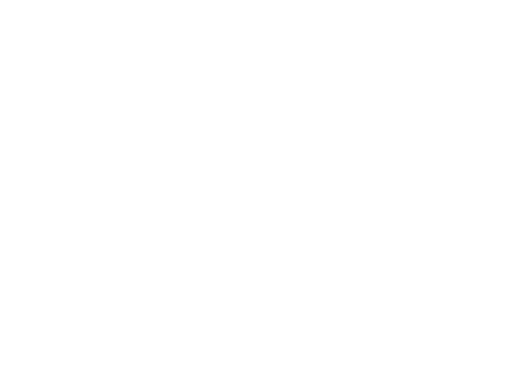

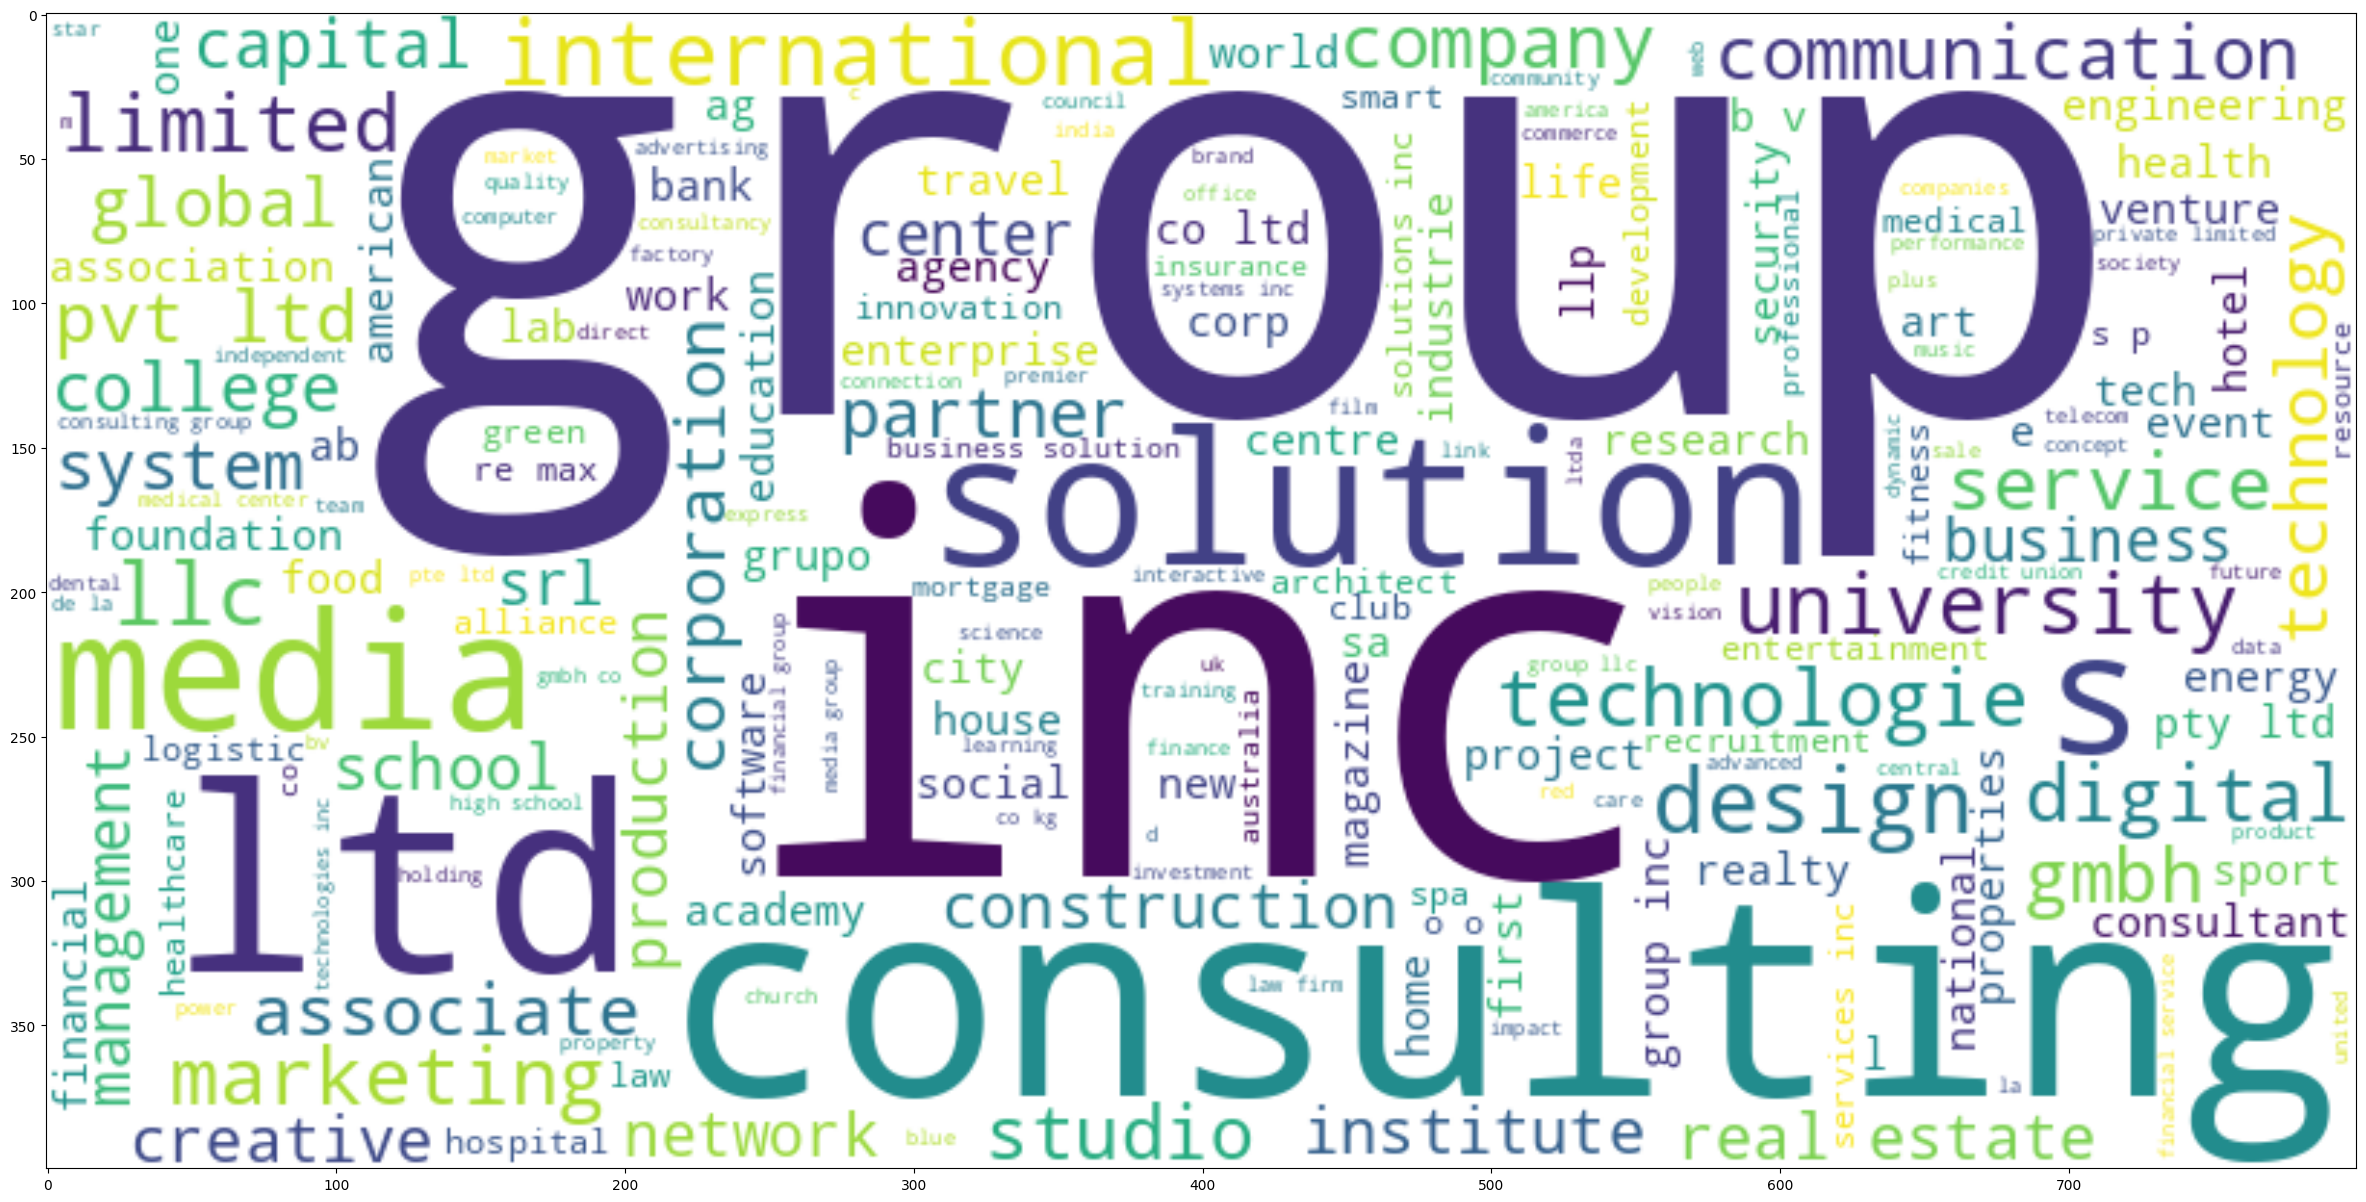

In [36]:
text = " ".join(name for name in df[df.name.isin(repeated_names)].name)

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

The most frequent words in these repeating company names are common words like group, inc, consulting and solution. Having companines with the exact same name in our dataset will conflict with our objective of extracting insights from business names since the values in the other columns differ. So I will remove the companies with their names repeated.

In [37]:
df = df[~df.name.isin(repeated_names)]

Let us examine if there are names containing different kinds of characters other than the english alphabets and space.

In [38]:
# filtering names with a character that is not an english alphabet or space
regexp = re.compile(r'[^a-zA-Z\s]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

9                                        at&t
17                       jpmorgan chase & co.
30                     mcdonald's corporation
57           ayatama energi, trisco nusantara
70            secretaría de educación pública
                          ...                
7173397        stone center for yoga & health
7173402                        woonartikel.nl
7173404                     squad sp. z o. o.
7173411    fuller, hadeed, & ros-planas, pllc
7173416                       fit plus s.r.o.
Name: name, Length: 2069320, dtype: string

In [39]:
# filtering names with non-aschii characters, here I considered on the standard aschii characters
regexp = re.compile(r'[^\x00-\x7f]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

70                           secretaría de educación pública
81                               verbum traducción y edición
93                                                   l'oréal
168                                   mondelēz international
208                                            itaú unibanco
                                 ...                        
7173288                          uab „plius“ filiāle latvija
7173295           efenex - eficiencia energética extremadura
7173307                                      stora sjöfallet
7173316    versorgungs- und verkehrsgesellschaft saarbrüc...
7173334                iglesia presbiteriana príncipe de paz
Name: name, Length: 286532, dtype: string

In [40]:
# filtering names with digits
regexp = re.compile(r'[0-9]')
df[df.name.apply(lambda x: regexp.search(x)).astype('bool')].name

132                        3m health care
456                           century 21®
1074               level 3 communications
1179                           forever 21
1317                      24 hour fitness
                        ...              
7173166               professionals2match
7173169                    smpn 4 ngaglik
7173364                sia ekspresis 1818
7173378           304000 medienkreationen
7173386    agile4ever consulting services
Name: name, Length: 177123, dtype: string

As shown above there are a lot of names with digits, punctuations and aplhabets from non-english languages. This is understandable as this dataset conatains companies from different countries. Now let us look for the most comon words in company names.

To display all the names (145,466,613), it will cause system clash due to the RAM limitation.
Only top 100,000,000 will be displayed as a counter was imported.

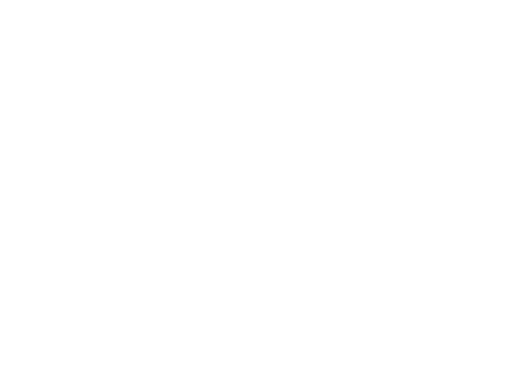

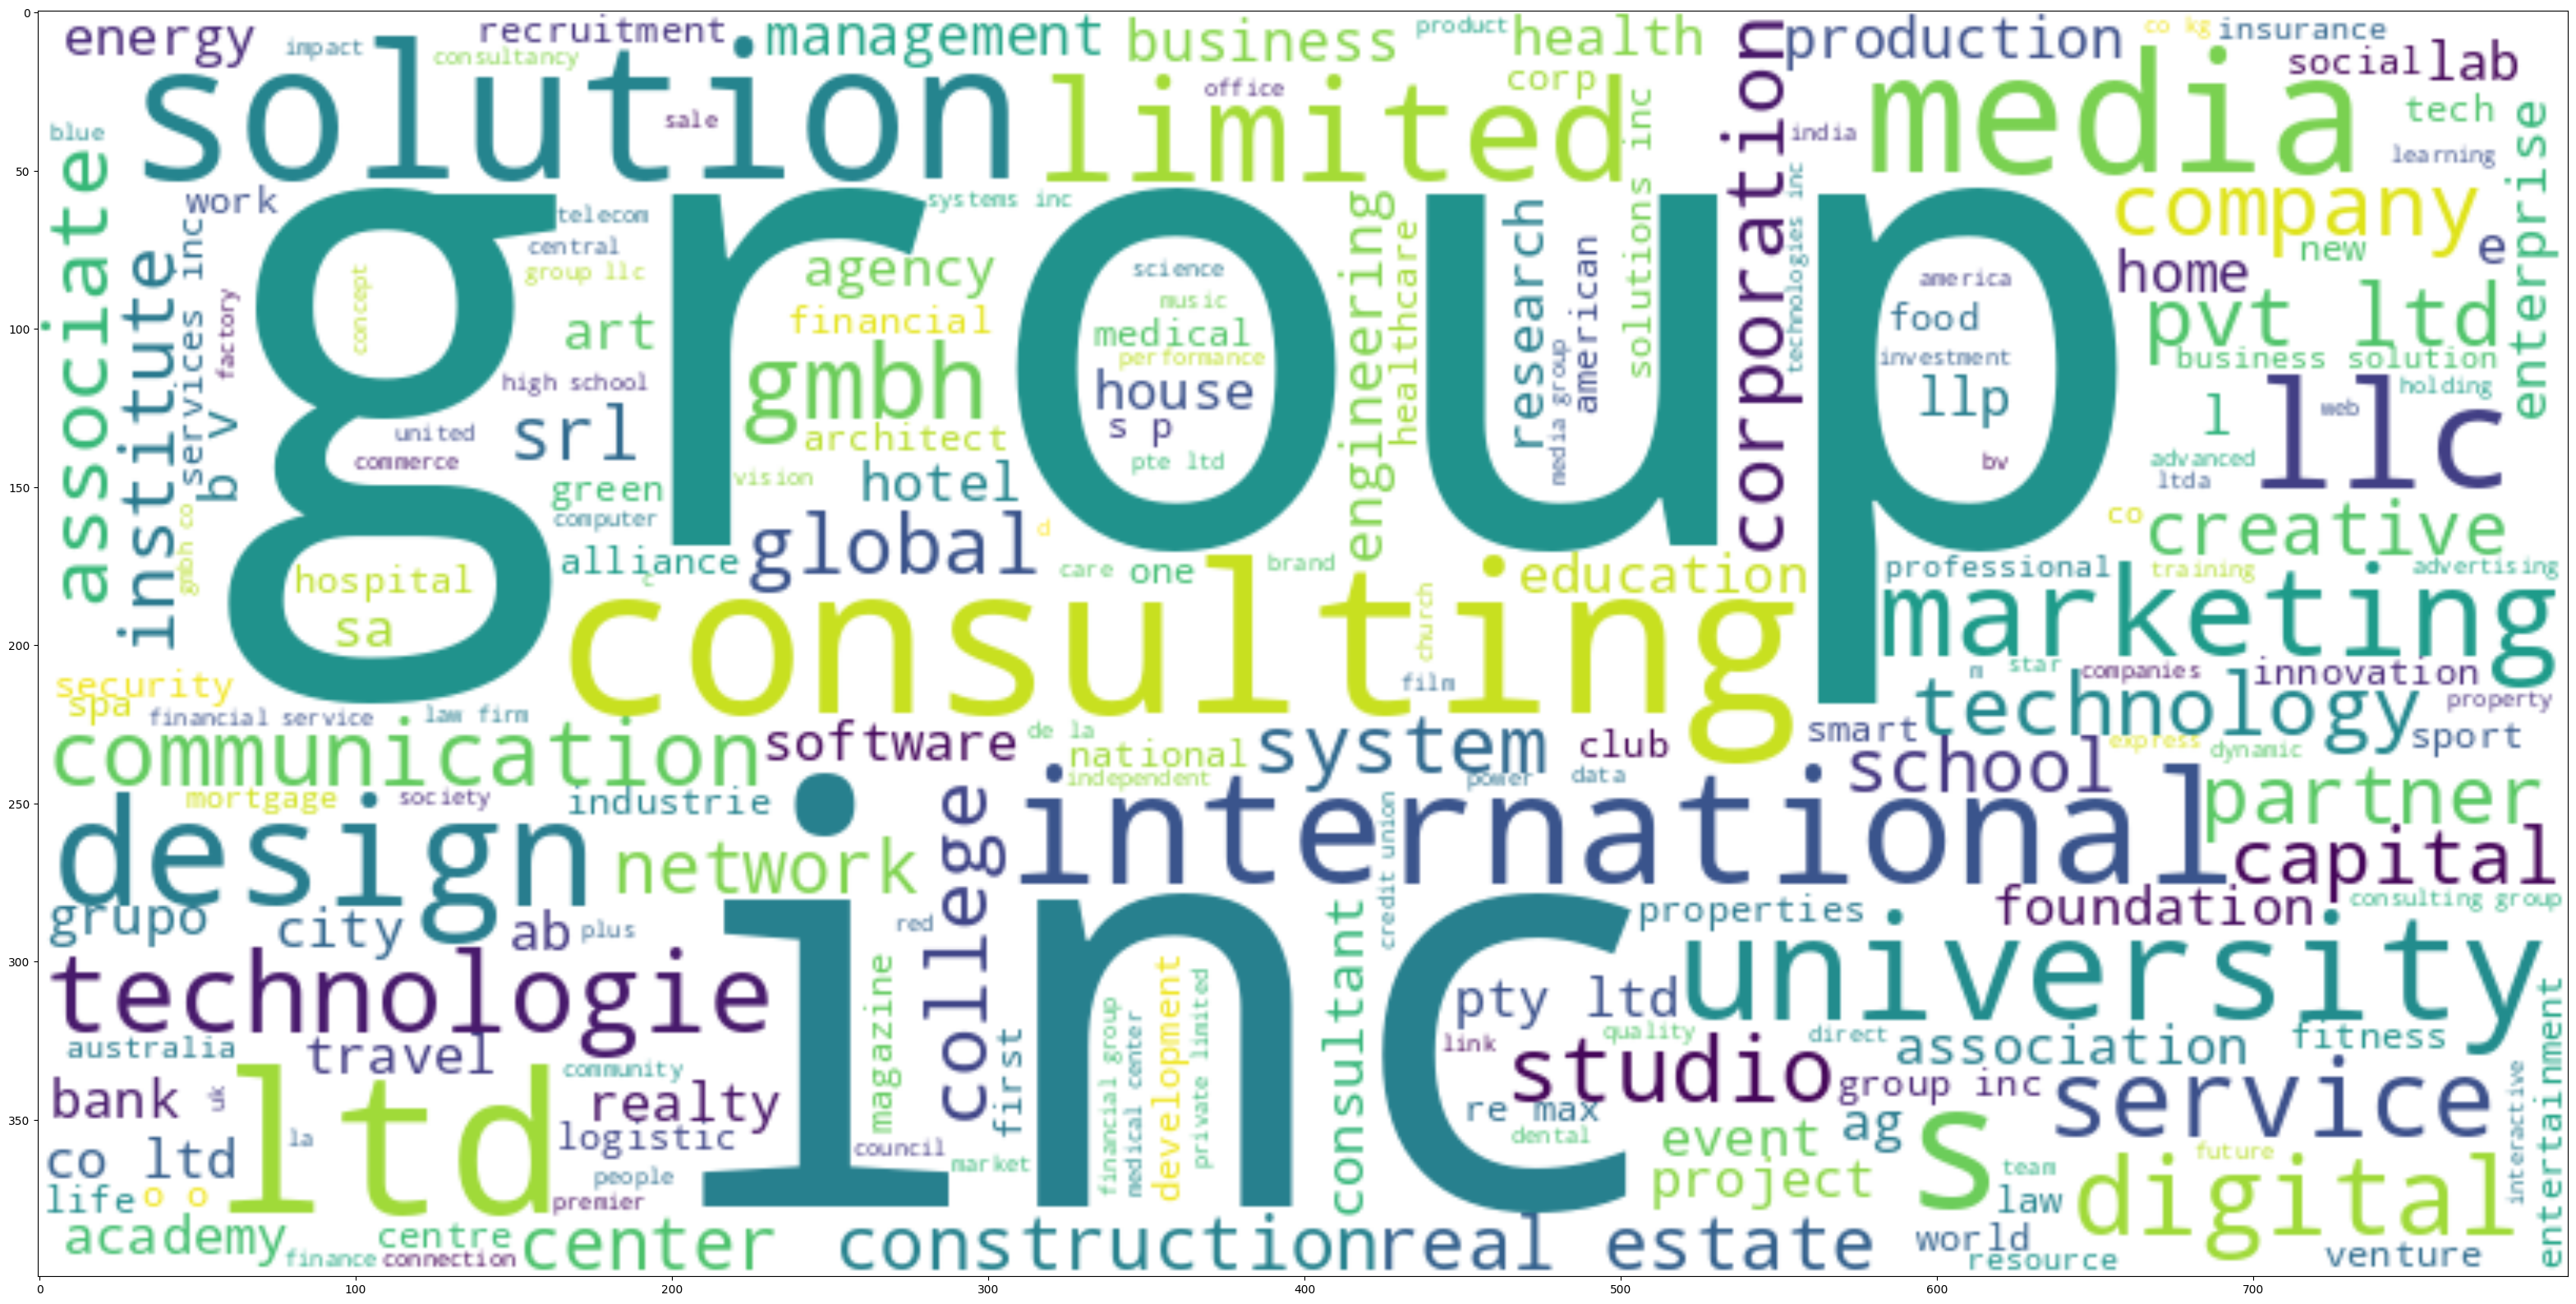

In [41]:
text = text[:100000000]

# generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(text)

# display the word cloud
plt.axis("off")
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

We can conclude the following from the word cloud.
* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).

### Domain

In [ ]:
# unique value counts
counts_df = df['domain'].value_counts().rename_axis('domain').reset_index(name='count')
counts_df

domain  count
0                        nordalps.com     12
1                       virtualcu.net      8
2                     lausd.k12.ca.us      6
3                          dunked.com      6
4               pradocapitalgroup.com      5
...                               ...    ...
3615306                      eager.no      1
3615307                 cura365.co.uk      1
3615308               krinklewood.com      1
3615309                     tiikr.com      1
3615310  dynamiccontrolssolutions.com      1

[3615311 rows x 2 columns]

In [ ]:
df[df['domain'] == 'dunked.com']

name      domain  year founded        industry  \
3289446  alex mitchell studios, llc  dunked.com          2003          design   
3467730     nomad design associates  dunked.com          2017          design   
3938133                 totdetweede  dunked.com          2010  graphic design   
4006830            creative inkling  dunked.com          2017          design   
4496938                  rjs design  dunked.com             0          design   
5124083                 all rounder  dunked.com          2010       animation   

        size range                                 locality         country  \
3289446     1 - 10          atlanta, georgia, united states   united states   
3467730     1 - 10   london, greater london, united kingdom  united kingdom   
3938133     1 - 10  bergambacht, south holland, netherlands     netherlands   
4006830     1 - 10        godalming, surrey, united kingdom  united kingdom   
4496938     1 - 10    lansdale, pennsylvania, united states   united states   
5124083     1 - 10              barcelona, catalonia, spain           spain   

                                           linkedin url  \
3289446  linkedin.com/company/alex-mitchell-studios-llc   
3467730    linkedin.com/company/nomad-design-associates   
3938133                linkedin.com/company/totdetweede   
4006830           linkedin.com/company/creative-inkling   
4496938                  linkedin.com/company/rjsdesign   
5124083                linkedin.com/company/all-rounder   

         current employee estimate  total employee estimate  
3289446                          1                        1  
3467730                          1                        1  
3938133                          1                        1  
4006830                          1                        1  
4496938                          1                        1  
5124083                          1                        1

We can see that there are companies with the same domain but different name. I assume that there was an error while collecting this data or the data was imputed using some criterea. I am saying this because even sister companies have different domains most of the times. Besides this for example companies with the domain 'dunked.com' are from different countries as shown above. This shows that there is low probability of them being sister companies. But since our objective doesn't focus on the domain, we will not drop them.

### Year founded

In [ ]:
# unique value counts
counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')
counts_df

year founded    count
0               0  1196367
1            2014   143899
2            2015   141830
3            2013   139259
4            2012   136035
..            ...      ...
227          2023        1
228          1789        1
229          1799        1
230          1451        1
231          1792        1

[232 rows x 2 columns]

As shown above there are some historical companies founded before 1900s. Besides this 0 is the most common value because we have repaced null values with it. Let us examine how many companies were founded before the 20th century.

In [ ]:
df.query("0 < `year founded` < 1900")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0            1898    745
1            1896    663
2            1890    648
3            1895    610
4            1889    598
..            ...    ...
98           1802     27
99           1451      1
100          1789      1
101          1799      1
102          1792      1

[103 rows x 2 columns]

It seems that there are some companies founded in the 19th century. What about before the 19th century?

In [ ]:
df.query("0 < `year founded` < 1800")['year founded'].value_counts().rename_axis('year founded').reset_index(name='count')

year founded  count
0          1789      1
1          1451      1
2          1799      1
3          1792      1

Earlier we have disovered that the maximum value is 2103. Let us check for vaules bigger than the current year.

In [ ]:
df[df['year founded'] > 2021]

name                      domain  \
478790     islamabad recruitment company(irco)                 irco.com.pk   
1000988             st. louis physical therapy                   stlpt.com   
1685181                              nativalab               nativalab.com   
1911596                        royal knight ag  royalknightagriculture.com   
2802880  b.s.b. international career pvt.  ltd     bsbinternational.org.uk   
2939095                       creativwire inc.             creativwire.com   
3147954                      stern corporation                sterncorp.jp   
6198686              kass marketing group, llc           kassmarketing.com   

         year founded                      industry size range  \
478790           2029  health, wellness and fitness   51 - 200   
1000988          2022  health, wellness and fitness    11 - 50   
1685181          2023                        design    11 - 50   
1911596          2027                       farming     1 - 10   
2802880          2025               human resources     1 - 10   
2939095          2103                      internet     1 - 10   
3147954          2022               mining & metals     1 - 10   
6198686          2022     marketing and advertising     1 - 10   

                                      locality        country  \
478790          islamabad, islamabad, pakistan       pakistan   
1000988  chesterfield, missouri, united states  united states   
1685181                milano, lombardy, italy          italy   
1911596  bensalem, pennsylvania, united states  united states   
2802880           calcutta, west bengal, india          india   
2939095      new york, new york, united states  united states   
3147954                    tokyo, tokyo, japan          japan   
6198686       carrollton, texas, united states  united states   

                                              linkedin url  \
478790   linkedin.com/company/islamabad-recruitment-com...   
1000988     linkedin.com/company/st-louis-physical-therapy   
1685181                     linkedin.com/company/nativalab   
1911596               linkedin.com/company/royal-knight-ag   
2802880  linkedin.com/company/b-s-b-international-caree...   
2939095              linkedin.com/company/creativwire-inc-   
3147954             linkedin.com/company/stern-corporation   
6198686      linkedin.com/company/kass-marketing-group-llc   

         current employee estimate  total employee estimate  
478790                          19                       34  
1000988                          8                       38  
1685181                          4                        9  
1911596                          3                        4  
2802880                          2                        2  
2939095                          2                        3  
3147954                          2                        2  
6198686                          0                        1

Let us remove these records.

In [ ]:
df.drop(df.index[df['year founded'] > 2021], inplace=True)

Since most companies in the dataset are founded after 1900, let's see their distribution.

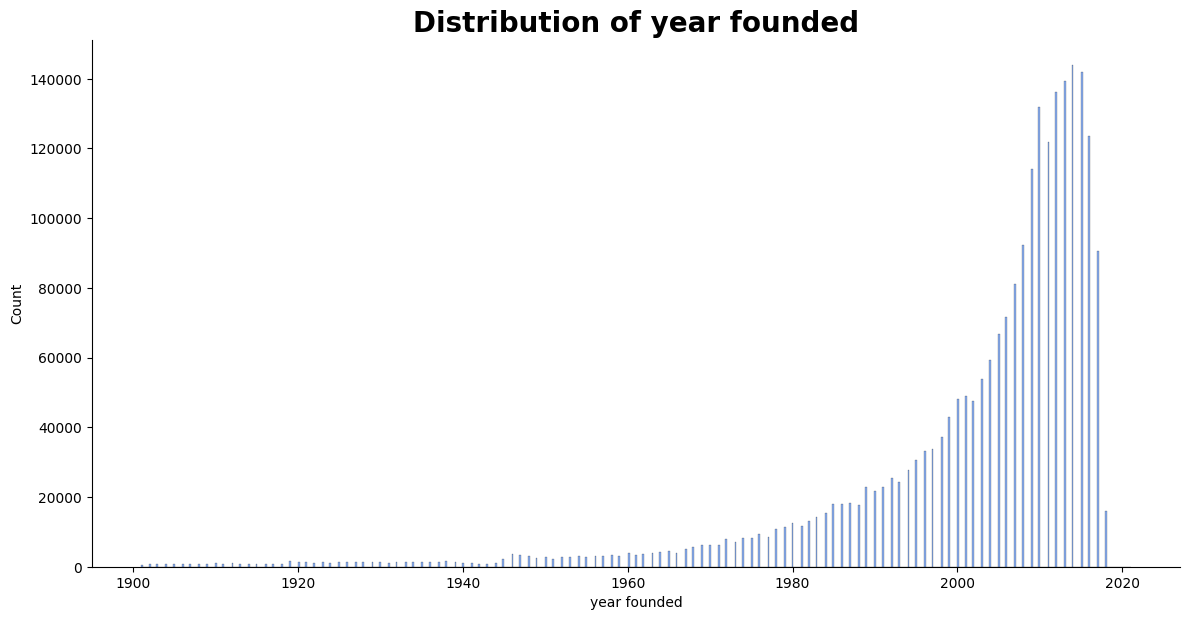

In [ ]:
# distribution of companies founded after 1900
plot_dist(df[df['year founded'] > 1900], 'year founded')

### Industry

In [ ]:
# unique value counts
counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='count')
counts_df

industry   count
0    information technology and services  241878
1              marketing and advertising  185119
2                           construction  143285
3                            real estate  105494
4                  management consulting  100558
..                                   ...     ...
143                         supermarkets    1155
144                             ranching    1094
145                 railroad manufacture     820
146                              tobacco     631
147                   legislative office     184

[148 rows x 2 columns]

The companies in this dataset work in 148 industries. The most common industry is 'infomation technoogy and services'.

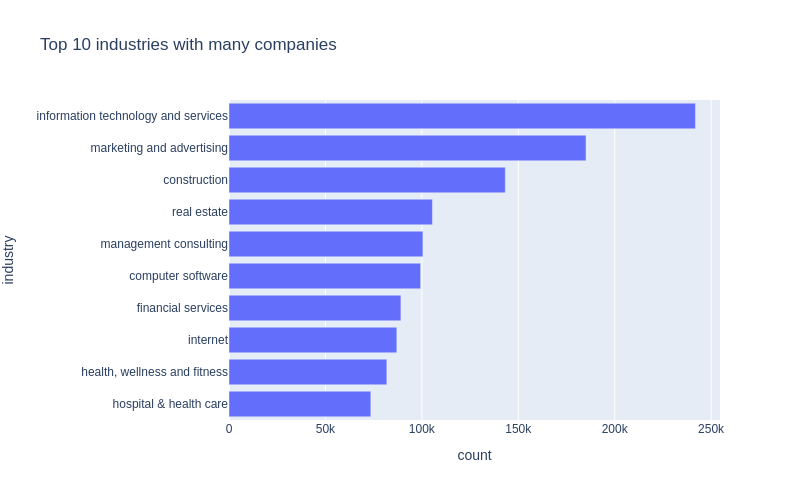

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with many companies')

### Size range

In [ ]:
# unique value counts
counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='count')
counts_df

size range    count
0        1 - 10  2652155
1       11 - 50   692311
2      51 - 200   204469
3     201 - 500    46999
4    501 - 1000    16416
5   1001 - 5000    13937
6  5001 - 10000     1735
7        10001+     1047

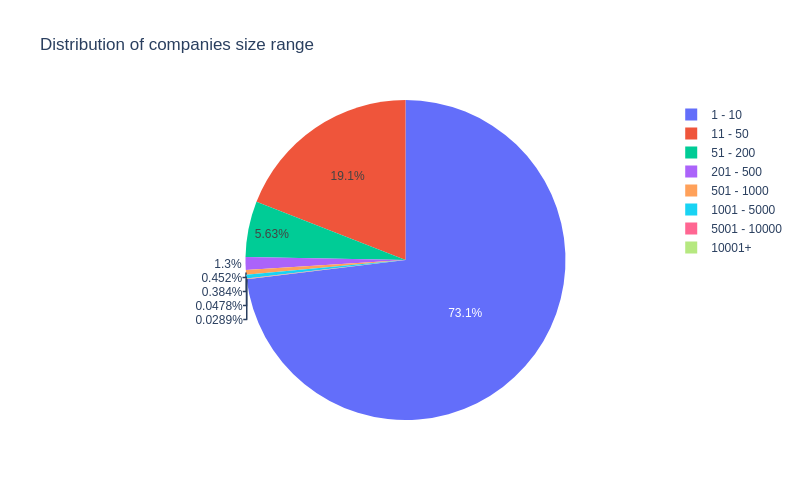

In [ ]:
plotly_plot_pie(df, column='size range', title='Distribution of companies size range', width=800)

More than 93% of the companies have employees less than or equal to 50. I think this shows the reaity since the number of big companies that drive economies around the world is small.

### Locality

In [ ]:
# unique value counts
counts_df = df['locality'].value_counts().rename_axis('locality').reset_index(name='count')
counts_df

locality  count
0          london, greater london, united kingdom  64310
1               new york, new york, united states  52193
2                           madrid, madrid, spain  33629
3                    paris, île-de-france, france  28342
4                chicago, illinois, united states  24751
...                                           ...    ...
88568                  goianapolis, goias, brazil      1
88569              bernterode, thuringia, germany      1
88570  misenheimer, north carolina, united states      1
88571         androhibe, antananarivo, madagascar      1
88572           foxboro, wisconsin, united states      1

[88573 rows x 2 columns]

Here we can see that most companies are found in the biggest cities of the developed world like london, new york, madrid and paris. Another thing to notice is that london appears both at index 0 and 4 with slight difference. This shows there is an inconsistency. We will extract the cities as a feature later to fix this.

### Country

In [ ]:
# unique value counts
counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='count')
counts_df

country    count
0          united states  1657659
1         united kingdom   335827
2                 canada   146580
3            netherlands   121598
4                  india   120311
..                   ...      ...
226                samoa        1
227  u.s. virgin islands        1
228         saint helena        1
229                tonga        1
230              eritrea        1

[231 rows x 2 columns]

Here also as expected most companies are from the developes countries.The top 10 countries with many companies are plotted below.

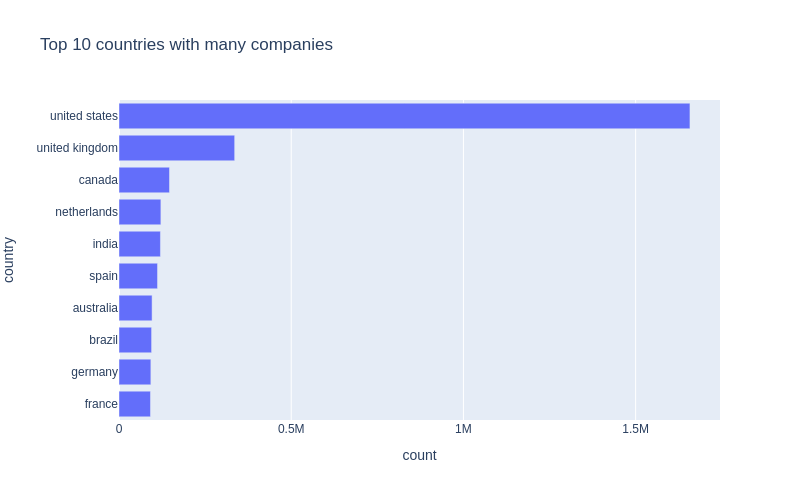

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='country', title='Top 10 countries with many companies')

 Companies from the united states clearly dominate the dataset.

### Linkedin url

In [ ]:

counts_df = df['linkedin url'].value_counts().rename_axis('linkedin url').reset_index(name='count')
counts_df

linkedin url  count
0           linkedin.com/company/tata-consultancy-services      1
1                              linkedin.com/company/huawei      1
2                     linkedin.com/company/lockheed-martin      1
3                                linkedin.com/company/at&t      1
4                      linkedin.com/company/jpmorgan-chase      1
...                                                    ...    ...
3629064    linkedin.com/company/pickering-evennett-limited      1
3629065         linkedin.com/company/drain-master-plumbing      1
3629066              linkedin.com/company/caged-collective      1
3629067                        linkedin.com/company/fhrlaw      1
3629068  linkedin.com/company/dynamic-controls-solution...      1

[3629069 rows x 2 columns]

As shown above each company has its own unique linkedin url. This is because the name of the company, which is unique, is included in each url.

### Current employee estimate

In [ ]:
counts_df = df['current employee estimate'].value_counts().rename_axis('current employee estimate').reset_index(name='count')
counts_df

current employee estimate    count
0                             1  1106522
1                             0   552456
2                             2   520276
3                             3   288412
4                             4   186235
...                         ...      ...
4130                       3428        1
4131                       3424        1
4132                       3415        1
4133                       1410        1
4134                     190771        1

[4135 rows x 2 columns]

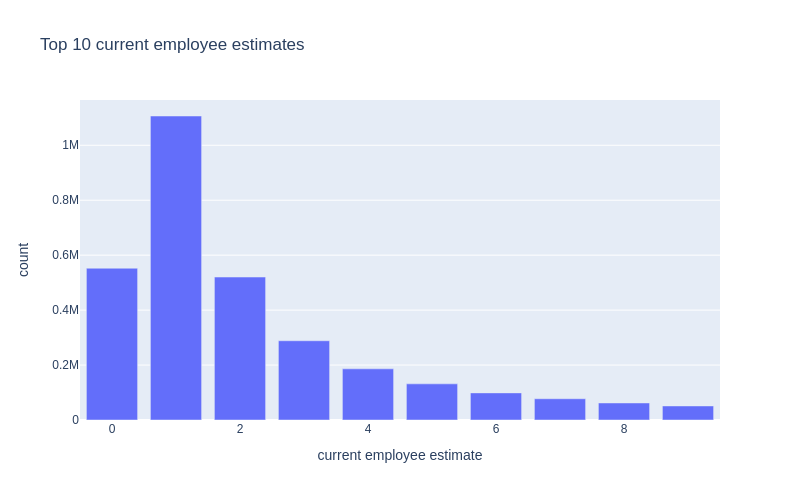

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='current employee estimate', y='count', title='Top 10 current employee estimates')

Everything seems fine here except for companies with 0 current employee estimate. I assume the data was not available for this companies so 0 was filled as an indication for missing.

### Total employee estimate

In [ ]:
counts_df = df['total employee estimate'].value_counts().rename_axis('total employee estimate').reset_index(name='count')
counts_df

total employee estimate    count
0                           1  1029802
1                           2   541091
2                           3   321968
3                           4   217877
4                           5   160399
...                       ...      ...
6692                     6784        1
6693                     3884        1
6694                     9623        1
6695                     3978        1
6696                   341369        1

[6697 rows x 2 columns]

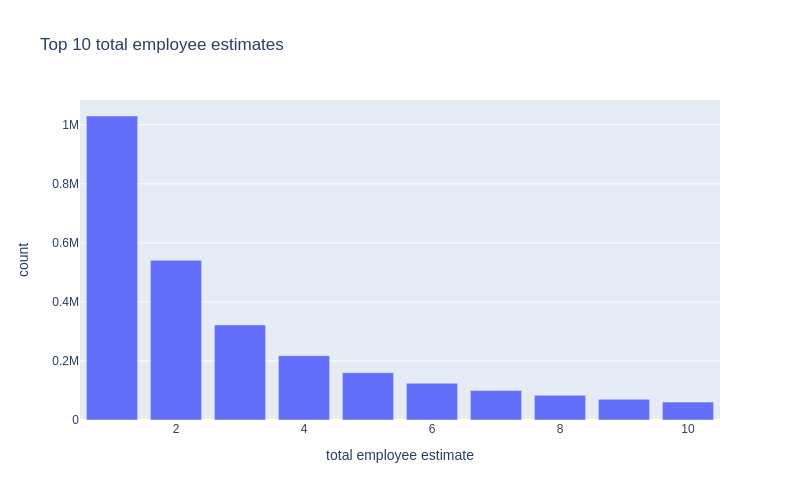

In [ ]:
plotly_plot_bar(counts_df.nlargest(10, 'count').sort_values(by='count'), x='total employee estimate', y='count', title='Top 10 total employee estimates')

Here 0 is the mode value for total employee estimate. I assume this is also due to missing data.

## Feature Engineering

From the locality column we can extract city which is useful to tackle the inconsistency discussed above in the univariate analysis of locality.

In [ ]:
def extract_city(locality):
    if pd.isnull(locality):
        return '<NA>'
    # extract cities from locality
    geo = geotext.GeoText(locality).cities
    if len(geo) > 0:
        return geo[0]
    return locality.split(',')[0]

df['city'] = df['locality'].apply(extract_city)

From the name we can extract different features like number of characters, words and punctuations. Another feature to be considered is word density. We can also identify if a name contains digits or non-aschii characters.

In [ ]:
df['name_char_count'] = df['name'].apply(lambda name: len(name))

# split name based on comma, space or hyphen
df['name_word_count'] = df['name'].apply(lambda name: len(list(filter(lambda x: x!= '', re.split(r',|\s|-', name)))))

df['name_word_density'] = round(df['name_word_count'] / df['name_char_count'], 2)

punc = string.punctuation
df['name_punc_count'] = df['name'].apply(lambda x : len([a for a in x if a in punc]))

df['name_non_aschii_char_count'] = df['name'].apply(lambda x: len([a for a in x if ord(a) > 127]))

df['name_digit_count'] = df['name'].apply(lambda x: len([a for a in x if a in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]))

For simplicity and ease of calculating correlation I will categorize the values of 'size range' into number values in an another column.

In [ ]:
def categorize(size):
    switcher={
        '1 - 10': 1,
        '11 - 50': 2,
        '51 - 200': 3,
        '201 - 500': 4,
        '501 - 1000': 5,
        '1001 - 5000': 6,
        '5001 - 10000': 7,
        '10001+': 8
    }
    return switcher.get(size, 0)
df['size_category'] = df['size range'].apply(categorize)
df.sample(5)

name                  domain  year founded  \
2961689        escapexperience  escapexperience.com.au          2015   
4059337    miguel modesto dsgn       miguelmodesto.com          2004   
1803003              znode inc               znode.com          2007   
6461446  top magazin frankfurt        top-frankfurt.de             0   
6702251          schiffko gmbh            schiffko.com             0   

               industry size range                             locality  \
2961689   entertainment     1 - 10        oakleigh, victoria, australia   
4059337  graphic design     1 - 10             lisbon, lisbon, portugal   
1803003        internet     1 - 10  milwaukee, wisconsin, united states   
6461446      publishing     1 - 10           frankfurt, hessen, germany   
6702251    oil & energy     1 - 10                 hoh, bayern, germany   

               country                                linkedin url  \
2961689      australia       linkedin.com/company/escapeexperience   
4059337       portugal    linkedin.com/company/miguel-modesto-dsgn   
1803003  united states              linkedin.com/company/znode-llc   
6461446        germany  linkedin.com/company/top-magazin-frankfurt   
6702251        germany          linkedin.com/company/schiffko-gmbh   

         current employee estimate  total employee estimate       city  \
2961689                          2                        3   oakleigh   
4059337                          1                        1     lisbon   
1803003                          4                       68  milwaukee   
6461446                          0                        2  frankfurt   
6702251                          0                        3        hoh   

         name_char_count  name_word_count  name_word_density  name_punc_count  \
2961689               15                1               0.07                0   
4059337               19                3               0.16                0   
1803003                9                2               0.22                0   
6461446               21                3               0.14                0   
6702251               13                2               0.15                0   

         name_non_aschii_char_count  name_digit_count  size_category  
2961689                           0                 0              1  
4059337                           0                 0              1  
1803003                           0                 0              1  
6461446                           0                 0              1  
6702251                           0                 0              1

## Correlation Analysis

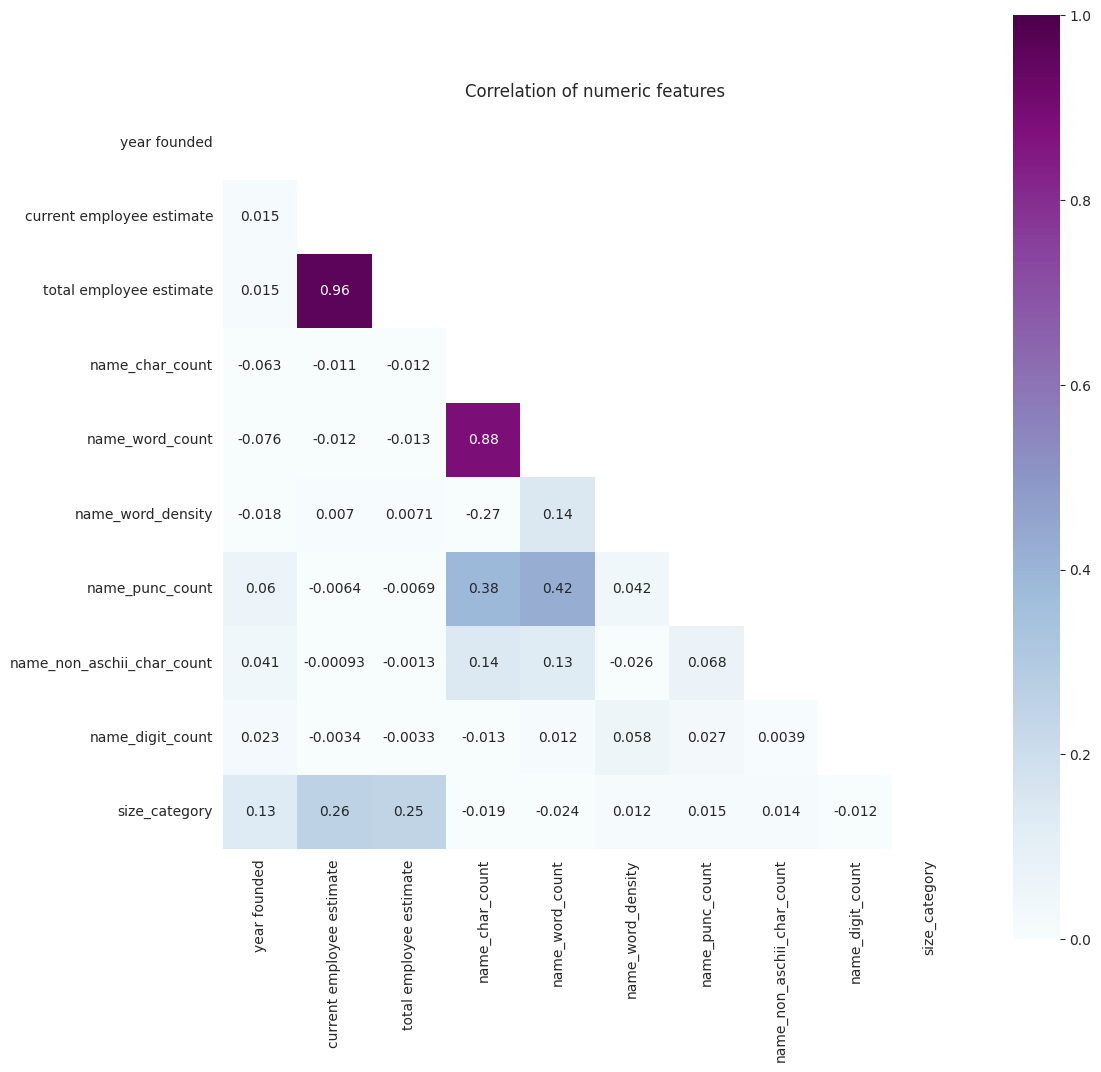

In [ ]:
df_corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f_fig, f_ax = plt.subplots(figsize=(12, 12))
    f_ax = sns.heatmap(df_corr, mask=mask, vmin=0, vmax=1, square=True,
                        annot=True, annot_kws={"size": 10}, cmap="BuPu")
plt.title('Correlation of numeric features')
plt.show()

As shown above there is no significant correlation between important numeric features. It is no surprise that 'current employee estimate' and 'total employee estimate' are highly correlated as they both describe the size of employees in companies. The same applies to numeric features engineered from the column name. They have correlation because they are derived from the same place. Due to these facts our bivariate analysis will mostly focus on non-numerical features and their interaction with the numerical features.

## Bivariate Analysis
### country and name_char_count
Here we will examine the averege number of characters in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_char_count': 'mean', 'name': 'count'}).rename(columns={'name_char_count': 'mean_name_char', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_char',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_char'] = country_df['mean_name_char'].astype('int16')
country_df

country  mean_name_char  count
0                  China              28  29696
1    Trinidad And Tobago              27    368
2                  Sudan              26    266
3            Afghanistan              25    343
4                   Oman              25    416
..                   ...             ...    ...
141              Iceland              16    916
142               France              16  91381
143               Norway              16  20709
144                Benin              16    190
145              Estonia              15   2806

[146 rows x 3 columns]

In [ ]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'geometry']]
gdf.columns = ['country', 'geometry']
gdf.head()

country                                           geometry
0                      Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1                  Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2                 W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3                    Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  United States of America  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [ ]:
# remove antarctica
antarctic_index = int(gdf[gdf['country'] == 'Antarctica'].index.values)
gdf = gdf.drop(gdf.index[antarctic_index])

replace = {
    "United States of America": 'United States',
    "Bosnia and Herz.": 'Bosnia And Herzegovina',
    "Central African Rep.": 'Central African Republic',
    "Côte d'Ivoire": 'Côte D’Ivoire',
    "Dominican Rep.": 'Dominican Republic',
    "Dem. Rep. Congo": 'Democratic Republic Of The Congo',
    "Eq. Guinea": 'Equatorial Guinea',
    "Dominican Rep.": 'Dominican Republic',
    "Solomon Is.": 'Solomon Islands',
    "Trinidad and Tobago": 'Trinidad And Tobago',
    "S. Sudan": 'South Sudan',
}

for (n_old, n_new) in replace.items():
    gdf.country.loc[gdf['country'] == n_old] = n_new

# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_char      count  
0            24.0      881.0  
1            22.0      936.0  
2             NaN        NaN  
3            22.0   146580.0  
4            21.0  1657659.0

In [ ]:
pip install mapclassify --upgrade


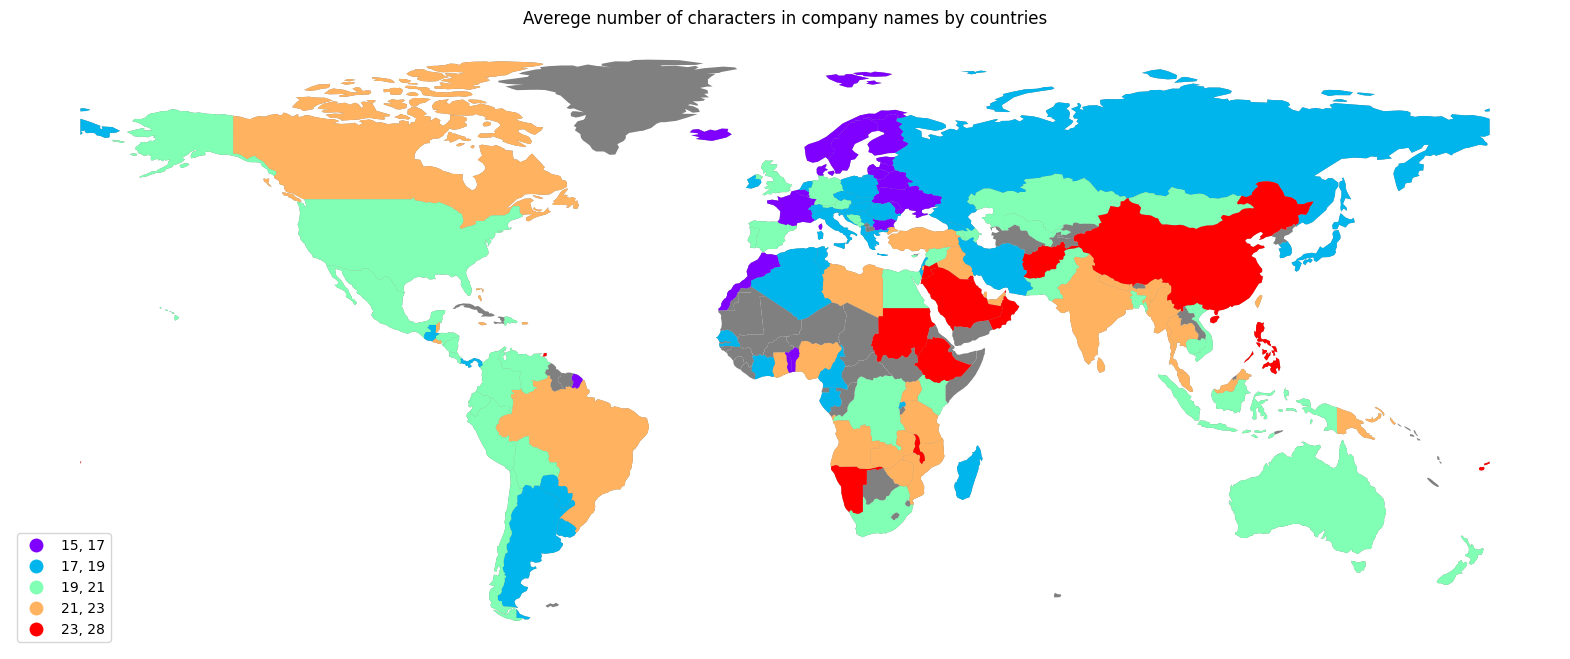

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_char', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

### country and name_word_count

Here we will investigate the averege number of words in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_word_count': 'mean', 'name': 'count'}).rename(columns={'name_word_count': 'mean_name_word', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_word',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_word'] = country_df['mean_name_word'].astype('int16')
country_df

country  mean_name_word  count
0                  China               4  29696
1                   Oman               3    416
2    Trinidad And Tobago               3    368
3                  Sudan               3    266
4                 Kuwait               3   1225
..                   ...             ...    ...
141              Denmark               2  25917
142              Belarus               2    912
143               France               2  91381
144              Iceland               2    916
145                Benin               2    190

[146 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_word      count  
0             3.0      881.0  
1             3.0      936.0  
2             NaN        NaN  
3             3.0   146580.0  
4             3.0  1657659.0

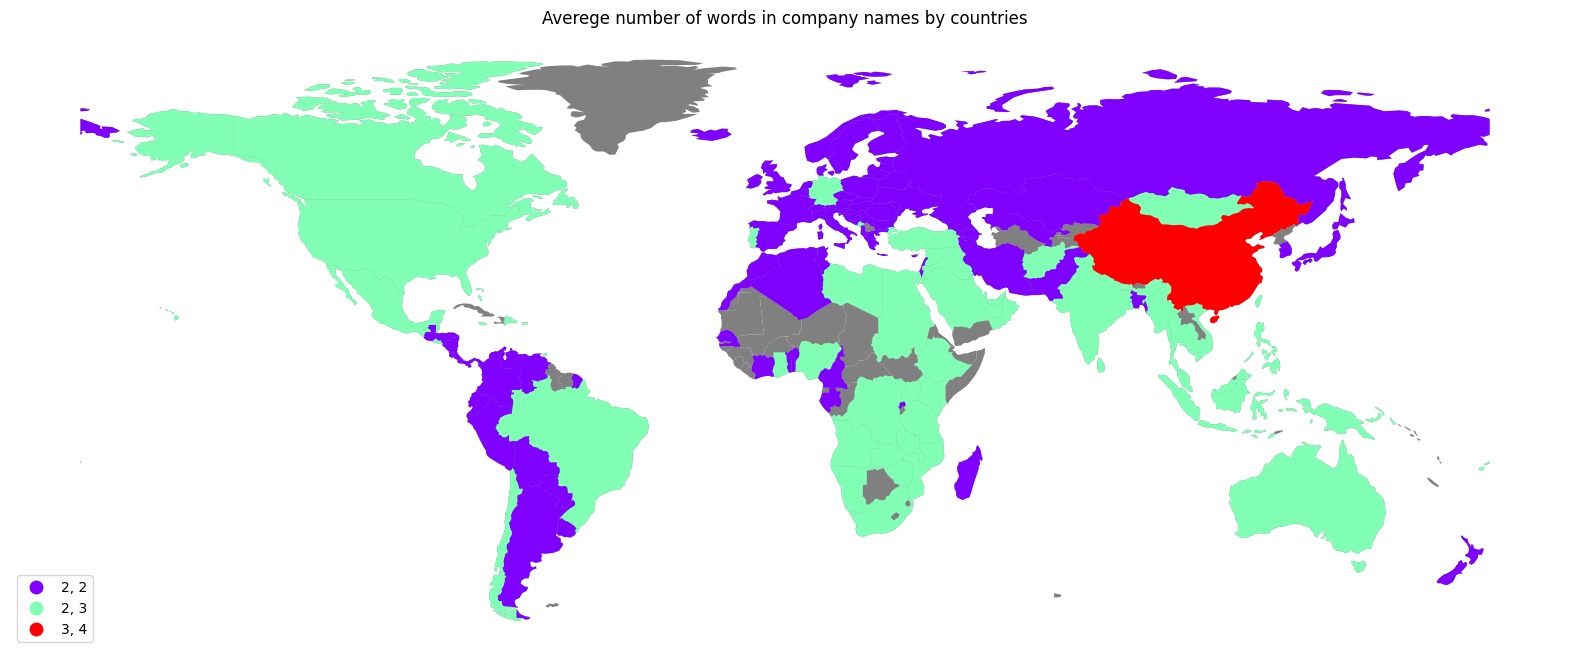

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_word', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of words in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

There is high similarity with the map showing averege number of characters in company names by countries. It is obvious as there is a correlation between number of characters and words. Some countries with high average number of characters have medium average number of words. I assume the words used by these countries are longer.

### country and name_punc_count

Now it is time for investigating the averege number of punctuations in company names per countries.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_punc_count': 'mean', 'name': 'count'}).rename(columns={'name_punc_count': 'mean_name_punct_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_punct_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_punct_count'] = country_df['mean_name_punct_count'].round(2)
country_df

country  mean_name_punct_count   count
0           Czechia                   1.56    9962
1          Slovakia                   1.50    3771
2          Slovenia                   1.46    2120
3             China                   1.34   29696
4           Croatia                   1.21    4222
..              ...                    ...     ...
141       Australia                   0.20   96059
142         Estonia                   0.20    2806
143  United Kingdom                   0.20  335827
144          Norway                   0.19   20709
145          Sweden                   0.16   30591

[146 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_punct_count      count  
0                   0.56      881.0  
1                   0.37      936.0  
2                    NaN        NaN  
3                   0.48   146580.0  
4                   0.48  1657659.0

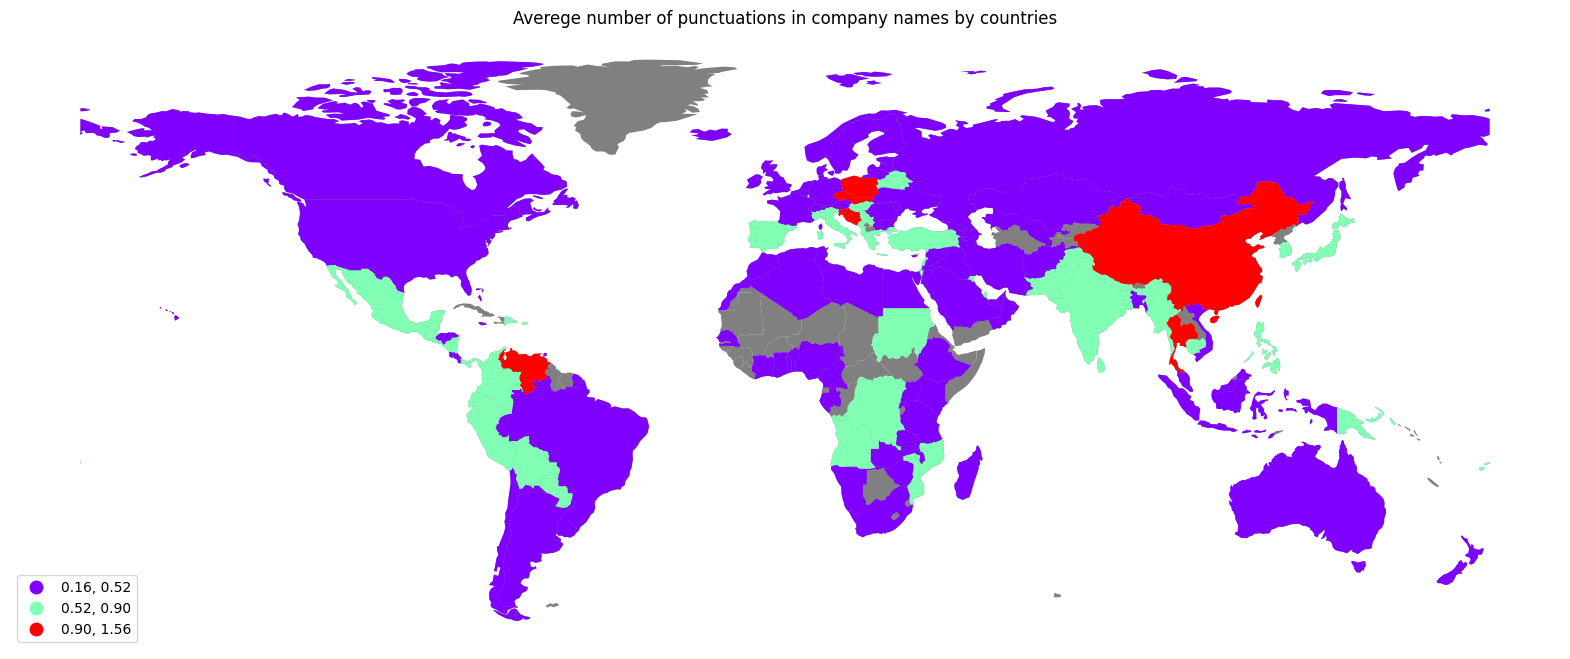

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_punct_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=3, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of punctuations in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Some countries in europe, the south east asia and south america have company names with a high probability of including a punctuation. Let's see who they are.

In [ ]:
country_df[country_df['mean_name_punct_count'] >= 1]

country  mean_name_punct_count  count
0                 Czechia                   1.56   9962
1                Slovakia                   1.50   3771
2                Slovenia                   1.46   2120
3                   China                   1.34  29696
4                 Croatia                   1.21   4222
5                Thailand                   1.07   4515
6               Venezuela                   1.03   3317
7                  Taiwan                   1.03   2800
8  Bosnia And Herzegovina                   1.00    870

### country and name_digit_count
Digits are not that much common in company name. But they appear in some names to represent something, for example, the year they were founded. Let's see if there is a relation between country and average number of digits in company names.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_digit_count': 'mean', 'name': 'count'}).rename(columns={'name_digit_count': 'mean_name_digit_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_digit_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_digit_count'] = country_df['mean_name_digit_count'].round(2)
country_df

country  mean_name_digit_count  count
0              Taiwan                   0.12   2800
1         South Korea                   0.11   1604
2           Venezuela                   0.10   3317
3             Curaçao                   0.09    192
4               Japan                   0.08   6763
..                ...                    ...    ...
141  Papua New Guinea                   0.01    119
142              Iraq                   0.01    602
143              Oman                   0.00    416
144           Bahamas                   0.00    249
145        Seychelles                   0.00    118

[146 rows x 3 columns]

The maximum value for average count of digits per country is 0.15 which is very low. This is expected as most company names doesn't include digits.

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_digit_count      count  
0                   0.01      881.0  
1                   0.04      936.0  
2                    NaN        NaN  
3                   0.05   146580.0  
4                   0.04  1657659.0

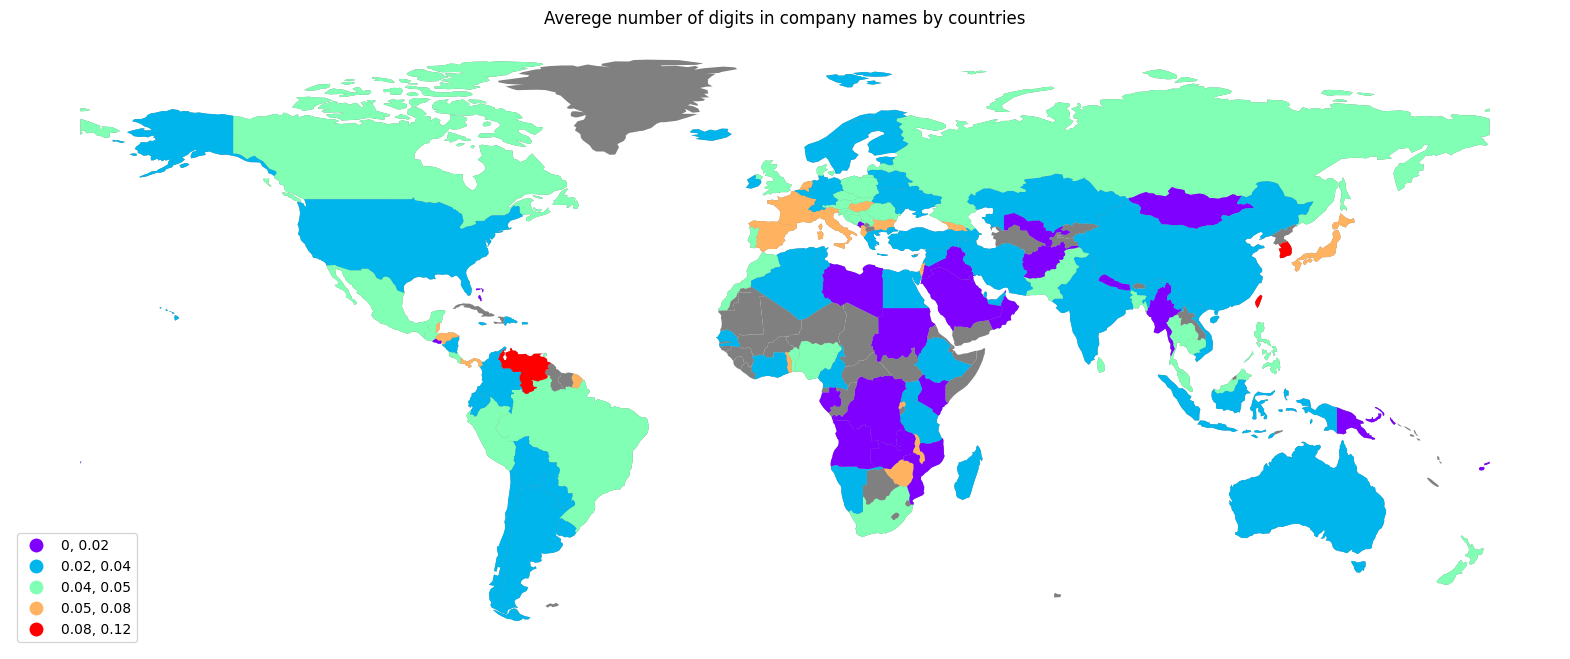

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_digit_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of digits in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

In [ ]:
country_df[country_df['mean_name_digit_count'] > 0.07]

country  mean_name_digit_count  count
0       Taiwan                   0.12   2800
1  South Korea                   0.11   1604
2    Venezuela                   0.10   3317
3      Curaçao                   0.09    192
4        Japan                   0.08   6763
5       Malawi                   0.08    130
6      Albania                   0.08    675

### country and name_non_aschii_char_count

Company names with non-aschii characters are probably going to be from non-english speaking countries. But the question is which countries have the highest number of average non-aschii characters. Let's find out.

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'name_non_aschii_char_count': 'mean', 'name': 'count'}).rename(columns={'name_non_aschii_char_count': 'mean_name_non_aschii_char_count', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_name_non_aschii_char_count',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_name_non_aschii_char_count'] = country_df['mean_name_non_aschii_char_count'].round(2)
country_df

country  mean_name_non_aschii_char_count  count
0                Belarus                             1.31    912
1                 Russia                             1.19  10354
2                 Turkey                             1.12  31654
3                   Iran                             1.05   6370
4             Kazakhstan                             0.96    807
..                   ...                              ...    ...
141  Trinidad And Tobago                             0.00    368
142               Zambia                             0.00    386
143               Belize                             0.00    186
144               Malawi                             0.00    130
145             Guernsey                             0.00    109

[146 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_name_non_aschii_char_count      count  
0                             0.17      881.0  
1                             0.00      936.0  
2                              NaN        NaN  
3                             0.05   146580.0  
4                             0.01  1657659.0

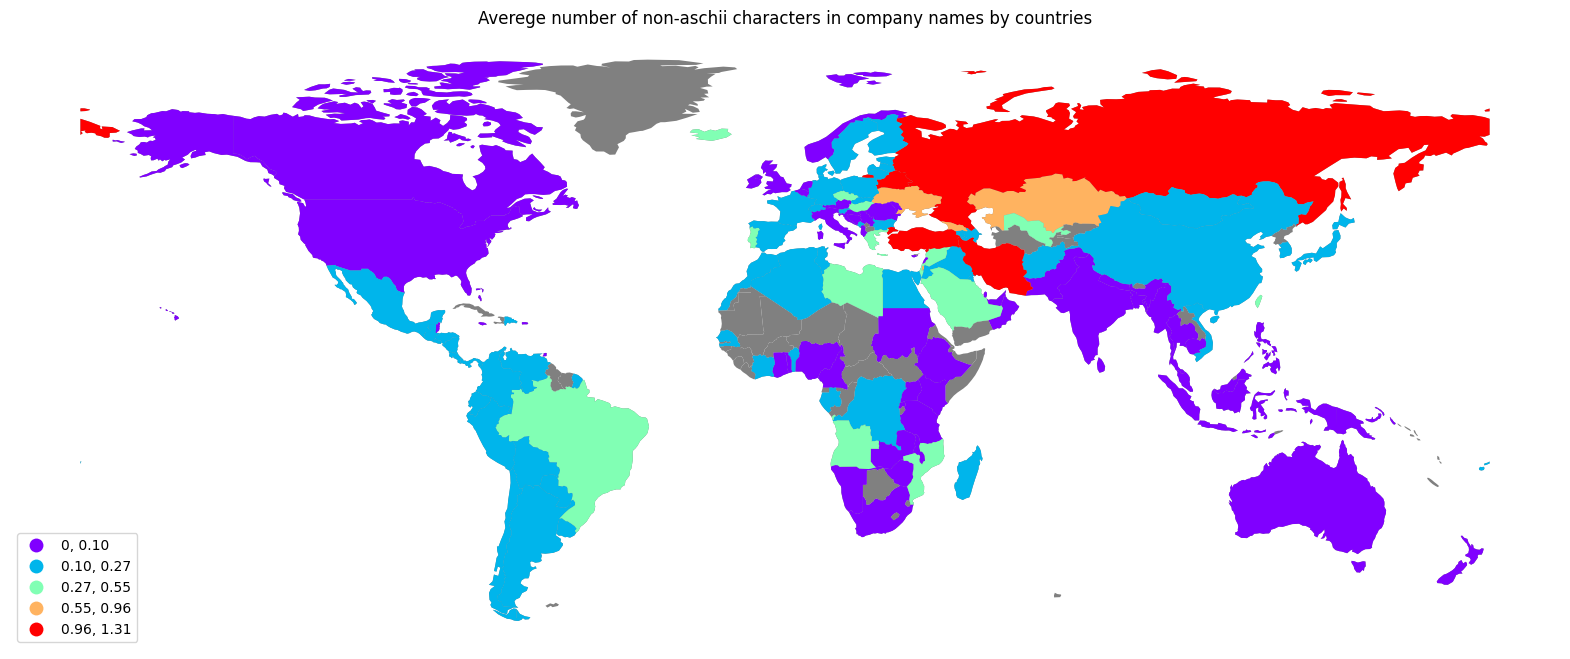

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_name_non_aschii_char_count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege number of non-aschii characters in company names by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

Let's find out which countries are coded by red.

In [ ]:
country_df[country_df['mean_name_non_aschii_char_count'] >= 0.97]

country  mean_name_non_aschii_char_count  count
0  Belarus                             1.31    912
1   Russia                             1.19  10354
2   Turkey                             1.12  31654
3     Iran                             1.05   6370

### country and size range

In [ ]:
country_df = df.groupby('country', as_index=False).agg({'size_category': 'mean', 'name': 'count'}).rename(columns={'size_category': 'mean_size_category', 'name': 'count'})
country_df =  country_df[country_df['count'] >= 100].sort_values(by='mean_size_category',ascending=False).reset_index(drop=True)
country_df['country'] = country_df['country'].astype('string').str.title()
country_df['mean_size_category'] = country_df['mean_size_category'].round(2)
country_df

country  mean_size_category    count
0            Jordan                2.08      331
1         Singapore                2.02     1186
2           Bermuda                1.93      184
3      Saudi Arabia                1.85     5818
4             Qatar                1.85     1911
..              ...                 ...      ...
141   United States                1.32  1657659
142           Benin                1.30      190
143       Australia                1.29    96059
144  United Kingdom                1.28   335827
145     Saint Lucia                1.20      191

[146 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

   mean_size_category      count  
0                1.69      881.0  
1                1.47      936.0  
2                 NaN        NaN  
3                1.35   146580.0  
4                1.32  1657659.0

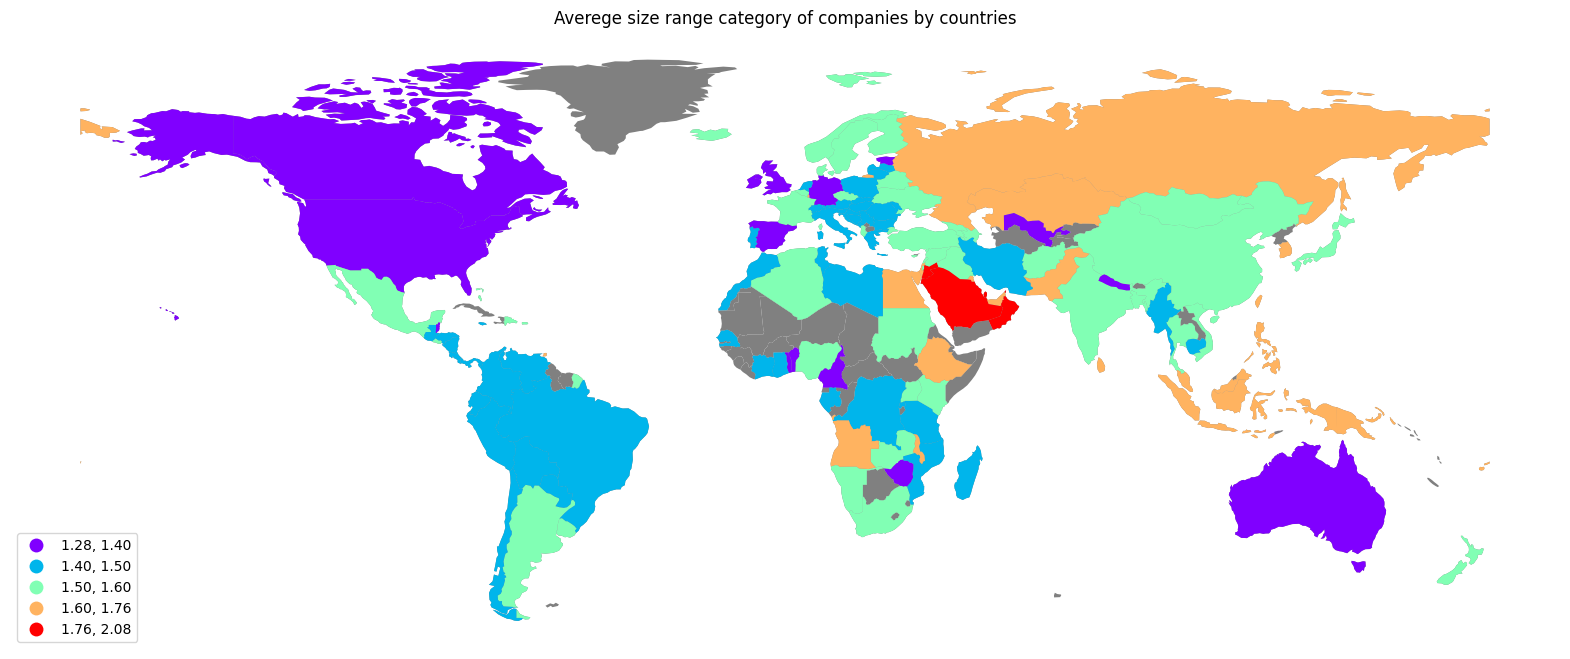

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='mean_size_category', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Averege size range category of companies by countries')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The mean size category ranges from 1.23 to 1.88 in every country with more than or equal to 100 companies in the dataset. This indicates that there are many small companies in these countries which is obvious. That is why the average is lower.

### name and industry
Here we will examine how many and which companies contain words from their respective industries in their names.

In [ ]:
def industry_in_name(row):
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    industry_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['industry'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in industry_words])
df['industry_word_in_name_count'] = df.apply(industry_in_name, axis=1)

In [ ]:
name_industry_df = df[df['industry_word_in_name_count'] > 0]
name_industry_df

name                        domain  \
1                 tata consultancy services                       tcs.com   
136             nyc department of education                       nyc.gov   
211          social security administration            socialsecurity.gov   
240                          lg electronics                        lg.com   
260                 alberta health services      albertahealthservices.ca   
...                                     ...                           ...   
7173236         harris shepard public rltns             harrisshepard.com   
7173248  cassubhai law pllc; bean law group              cassubhailaw.com   
7173274              fremont jewelry design      fremontjewelrydesign.com   
7173312               florida health choice  florida-health-insurance.net   
7173386      agile4ever consulting services                agile4ever.com   

         year founded                             industry size range  \
1                1968  information technology and services     10001+   
136                 0                 education management     10001+   
211              1935            government administration     10001+   
240              1947                 consumer electronics     10001+   
260              2008               hospital & health care     10001+   
...               ...                                  ...        ...   
7173236             0  public relations and communications     1 - 10   
7173248          2015                         law practice     1 - 10   
7173274             0               luxury goods & jewelry     1 - 10   
7173312             0               hospital & health care     1 - 10   
7173386          2013                management consulting     1 - 10   

                                       locality         country  \
1                    bombay, maharashtra, india           india   
136           new york, new york, united states   united states   
211          baltimore, maryland, united states   united states   
240        seoul, seoul-t'ukpyolsi, south korea     south korea   
260                   edmonton, alberta, canada          canada   
...                                         ...             ...   
7173236  los angeles, california, united states   united states   
7173248      seattle, washington, united states   united states   
7173274      seattle, washington, united states   united states   
7173312        florida, new york, united states   united states   
7173386  london, greater london, united kingdom  united kingdom   

                                              linkedin url  \
1           linkedin.com/company/tata-consultancy-services   
136       linkedin.com/company/nyc-department-of-education   
211                               linkedin.com/company/ssa   
240                    linkedin.com/company/lg-electronics   
260           linkedin.com/company/alberta-health-services   
...                                                    ...   
7173236   linkedin.com/company/harris-shepard-public-rltns   
7173248            linkedin.com/company/cassubhai-law-pllc   
7173274        linkedin.com/company/fremont-jewelry-design   
7173312    linkedin.com/company/florida-health-choice-inc-   
7173386  linkedin.com/company/agile4ever-consulting-ser...   

         current employee estimate  total employee estimate         city  \
1                           190771                   341369       bombay   
136                          30526                    45049     new york   
211                          21150                    28143    baltimore   
240                          19552                    47846        seoul   
260                          18502                    24861     edmonton   
...                            ...                      ...          ...   
7173236                          0                        1  los angeles   
7173248                          0                        1      seattle   
717

Let's explore these companies with respect to their country, size range, industry and year founded.

#### industry_word_in_name_count and country

In [ ]:
country_df = name_industry_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country   count  total_count
0     United States  196410      1657659
1    United Kingdom   36449       335827
2            Canada   19240       146580
3             India   12360       120311
4         Australia   11631        96059
..              ...     ...          ...
198      Micronesia       1            2
199         Burundi       1           26
200         Réunion       1           35
201           Samoa       1            1
202     South Sudan       1           15

[203 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry     count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     109.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...     101.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...       NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   19240.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  196410.0   

   total_count  
0          881  
1          936  
2         <NA>  
3       146580  
4      1657659

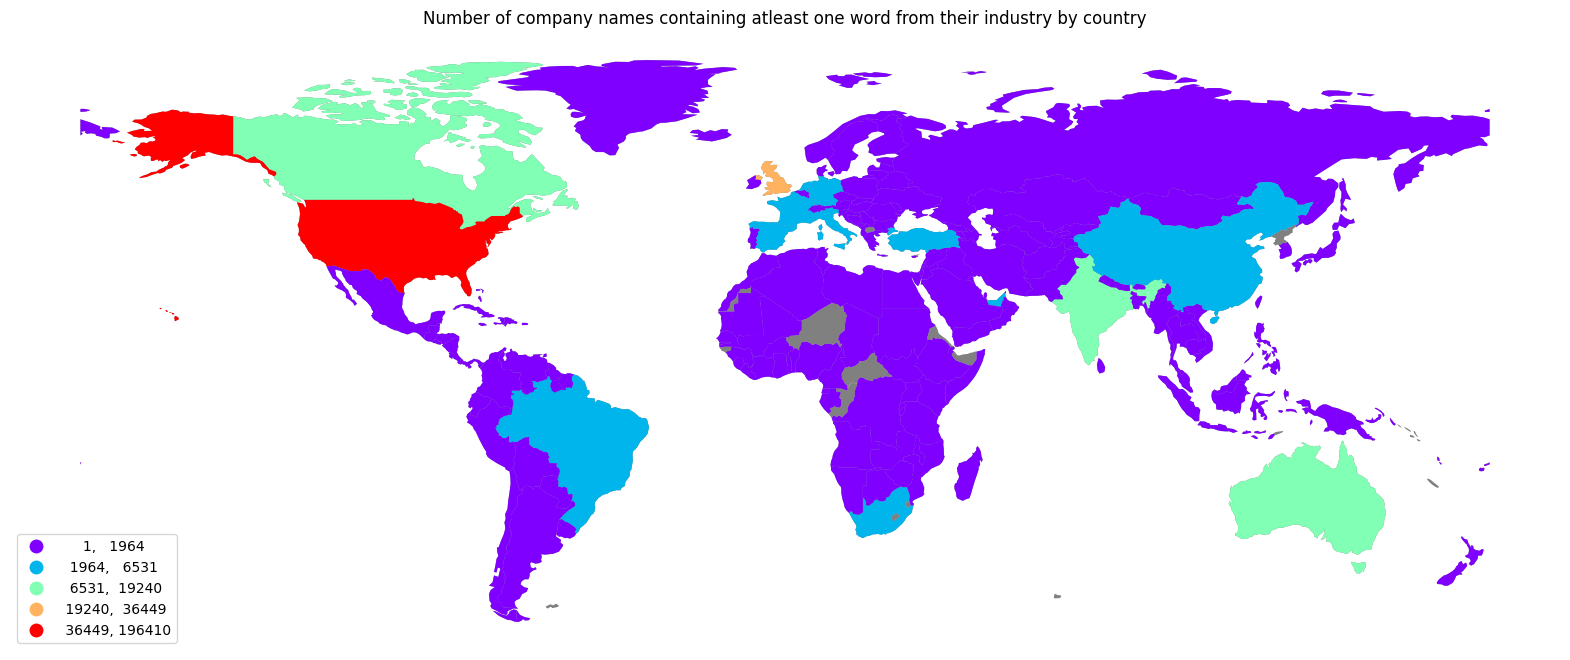

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their industry by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

The united states dominates here. But this maybe due to its high number of companies in the dataset as compared to other companies.

#### industry_word_in_name_count and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_industry_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range   count  total_count
0        1 - 10  267371      2652155
1       11 - 50   64847       692311
2      51 - 200   17975       204469
3     201 - 500    4087        46999
4    501 - 1000    1460        16416
5   1001 - 5000    1226        13937
6  5001 - 10000     171         1735
7        10001+      86         1047

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective industries. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### industry_word_in_name_count and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_industry_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0              marketing and advertising  25842       185119
1                  management consulting  17998       100558
2                           construction  16054       143285
3                              insurance  15593        40622
4    information technology and services  14806       241878
..                                   ...    ...          ...
139                              fishery     11         1185
140    nonprofit organization management     11         1668
141                         supermarkets      8         1155
142                   legislative office      8          184
143                            judiciary      3         1617

[144 rows x 3 columns]

In [ ]:
industry_df.head(10)

industry  count  total_count
0            marketing and advertising  25842       185119
1                management consulting  17998       100558
2                         construction  16054       143285
3                            insurance  15593        40622
4  information technology and services  14806       241878
5               hospital & health care  14304        73543
6                         law practice  14299        50961
7                          real estate  13015       105494
8                   financial services  12712        89133
9                               design  12210        61530

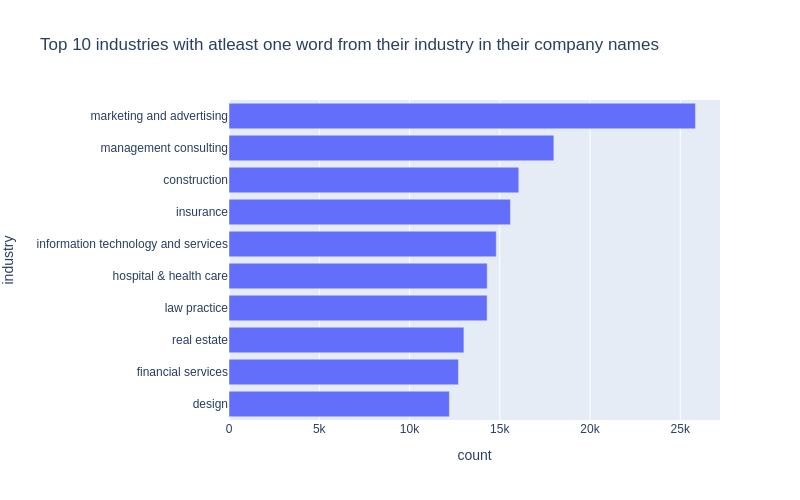

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their industry in their company names')

The bar chart plotted above shows top 10 industries with words from their respective industry in their company names.

#### industry_word_in_name_count and year founded

In [ ]:
year_df = name_industry_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0           2010  14201       131784
1           2013  13363       139259
2           2014  13362       143899
3           2012  13276       136035
4           2015  12863       141830
..           ...    ...          ...
212         1814      1           39
213         1827      1           45
214         1811      1           39
215         1829      1           61
216         1804      1           29

[217 rows x 3 columns]

In [ ]:
year_df.head(10)

year founded  count  total_count
0         2010  14201       131784
1         2013  13363       139259
2         2014  13362       143899
3         2012  13276       136035
4         2015  12863       141830
5         2009  12686       114187
6         2011  12428       121816
7         2016  11270       123636
8         2008   9971        92222
9         2007   8749        80997

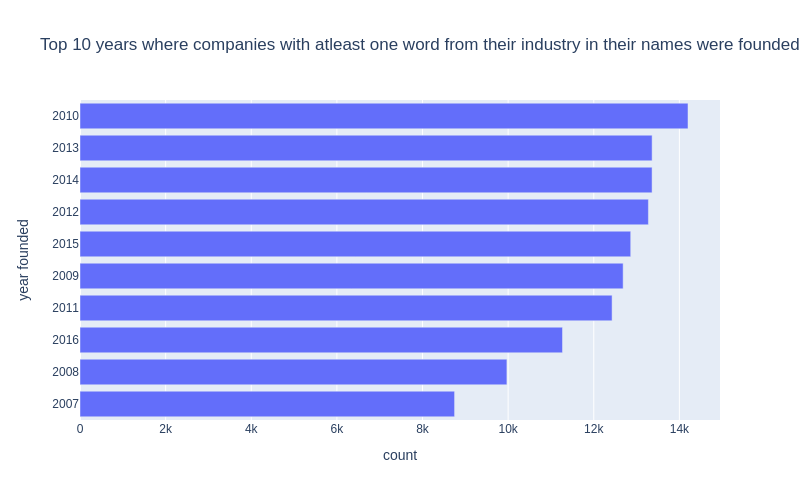

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their industry in their names were founded')

### name and locality

Here we will examine how many and which companies contain words from their respective localities in their names.

In [ ]:
def locality_in_name(row):
    if pd.isnull(row['locality']):
        return np.nan
    puncs = [punc for punc in string.punctuation]
    puncs.append('and')
    locality_words = set(filter(lambda x: x not in puncs, re.split(r'\s|-', row['locality'])))
    name_words = re.split(r'\s|-', row['name'])
    return len([i for i in name_words if i in locality_words])
df['locality_word_in_name_count'] = df.apply(locality_in_name, axis=1)

In [ ]:
name_locality_df = df[df['locality_word_in_name_count'] > 0]
name_locality_df

name  \
38                       department of veterans affairs   
160                                        saudi aramco   
174                 united states department of defense   
225                 los angeles unified school district   
239                                            emirates   
...                                                 ...   
7173035  global electrical & controls pvt. ltd. - india   
7173069              tabuchi electric hong kong limited   
7173176               ladies & gentlemen - south africa   
7173208                              iran model company   
7173370                                    cia do movel   

                           domain  year founded  \
38                         va.gov          1930   
160               saudiaramco.com          1933   
174                   defense.gov          1947   
225                     lausd.net          1853   
239                  emirates.com          1985   
...                           ...           ...   
7173035                 gecpl.org             0   
7173069                 zbr.co.jp             0   
7173176  ladiesandgentlemen.co.za          2011   
7173208             iranmodel.com          1984   
7173370     emporiodomovel.com.br          2002   

                                     industry size range  \
38                  government administration     10001+   
160                              oil & energy     10001+   
174                                  military     10001+   
225                      education management     10001+   
239                         airlines/aviation     10001+   
...                                       ...        ...   
7173035   electrical/electronic manufacturing     1 - 10   
7173069                               banking     1 - 10   
7173176                      media production     1 - 10   
7173208  mechanical or industrial engineering     1 - 10   
7173370                             furniture     1 - 10   

                                                locality  \
38       washington, district of columbia, united states   
160              dhahran, eastern province, saudi arabia   
174      washington, district of columbia, united states   
225               los angeles, california, united states   
239                   dubai, dubai, united arab emirates   
...                                                  ...   
7173035        gautam buddha nagar, uttar pradesh, india   
7173069                     wan chai, wanchai, hong kong   
7173176              johannesburg, gauteng, south africa   
7173208                             tehran, tehrān, iran   
7173370             igrejinha, rio grande do sul, brazil   

                      country  \
38              united states   
160              saudi arabia   
174             united states   
225             united states   
239      united arab emirates   
...                       ...   
7173035                 india   
7173069             hong kong   
7173176          south africa   
7173208                  iran   
7173370                brazil   

                                              linkedin url  \
38       linkedin.com/company/department-of-veterans-af...   
160                      linkedin.com/company/saudi-aramco   
174      linkedin.com/company/united-states-department-...   
225      linkedin.com/company/los-angeles-unified-schoo...   
239                          linkedin.com/company/emirates   
...                                                    ...   
7173035  linkedin.com/company/global-electrical-&-contr...   
7173069  linkedin.com/company/tabuchi-electric-hong-kon...   
7173176  linkedin.com/company/ladies-&-gentlemen---sout...   
7173208            linkedin.com/company/iran-model-company   
7173370              linkedin.com/company/empório-do-móvel   

         current employee estimate  total employee estimate  \
38                           62685                    86489   
160                

Let's explore these companies with respect to their country, size range, industry and year founded.

#### locality_word_in_name_count and country

In [ ]:
country_df = name_locality_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0       United States  34088      1657659
1               India  17707       120311
2           Australia   5875        96059
3              Canada   5180       146580
4              France   4674        91381
..                ...    ...          ...
199      Saint Helena      1            1
200          Kiribati      1           31
201  Marshall Islands      1           17
202        Micronesia      1            2
203     Åland Islands      1           45

[204 rows x 3 columns]

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry    count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    111.0   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    172.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...      NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   5180.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  34088.0   

   total_count  
0          881  
1          936  
2         <NA>  
3       146580  
4      1657659

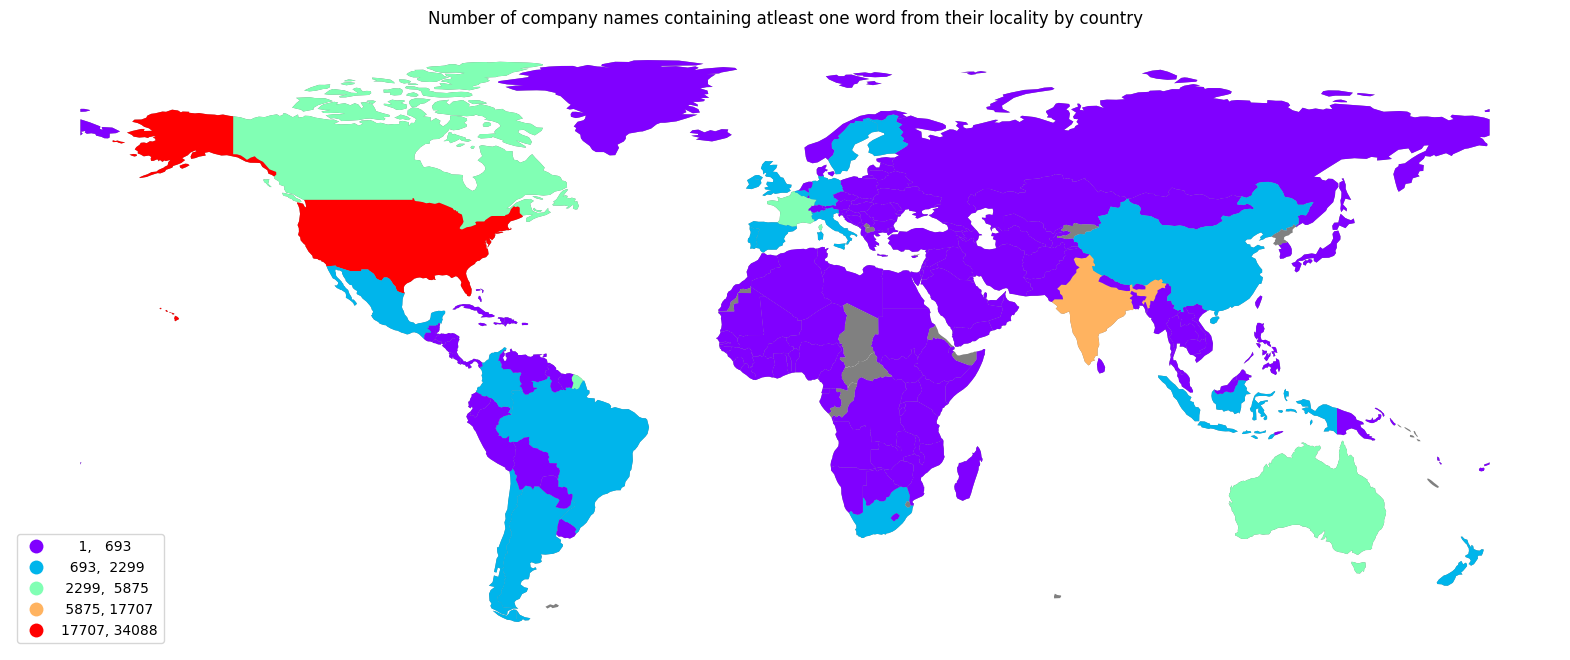

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing atleast one word from their locality by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### locality_word_in_name_count and size range

In [ ]:
size_df = name_locality_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0        1 - 10  73672      2652155
1       11 - 50  24224       692311
2      51 - 200   9089       204469
3     201 - 500   2578        46999
4    501 - 1000   1066        16416
5   1001 - 5000    983        13937
6  5001 - 10000    122         1735
7        10001+     75         1047

As we can see from the result above, small sized companies tend to have more companies with names conataining atleast a word from their respective localities. This aligns with the general distibution of size range. So I don't think there is a special connection here.

#### locality_word_in_name_count and industry

In [ ]:
industry_df = name_locality_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0    information technology and services   5555       241878
1     non-profit organization management   5297        61134
2                   education management   4381        64538
3              marketing and advertising   3511       185119
4                 hospital & health care   3200        73543
..                                   ...    ...          ...
143                       nanotechnology     32         1531
144                 railroad manufacture     31          820
145                              tobacco     29          631
146                         supermarkets     29         1155
147                   legislative office     15          184

[148 rows x 3 columns]

In [ ]:
industry_df.head(10)

industry  count  total_count
0  information technology and services   5555       241878
1   non-profit organization management   5297        61134
2                 education management   4381        64538
3            marketing and advertising   3511       185119
4               hospital & health care   3200        73543
5                          hospitality   3153        50783
6                          real estate   3082       105494
7                         construction   2649       143285
8            leisure, travel & tourism   2515        36067
9         health, wellness and fitness   2511        81847

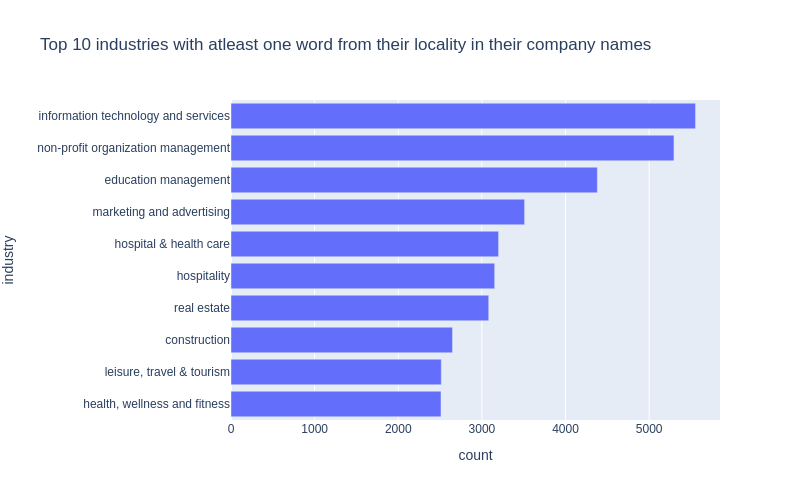

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with atleast one word from their locality in their company names')

The bar chart plotted above shows top 10 industries with words from their respective locality in their company names.

#### locality_word_in_name_count and year founded

In [ ]:
year_df = name_locality_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_df = year_df[year_df['year founded'] != 0]
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0           2012   3226       136035
1           2014   3182       143899
2           2013   3167       139259
3           2015   3086       141830
4           2010   2970       131784
..           ...    ...          ...
215         1451      1            1
216         1789      1            1
217         1819      1           45
218         1815      1           42
219         2019      1           12

[220 rows x 3 columns]

In [ ]:
year_df.head(10)

year founded  count  total_count
0         2012   3226       136035
1         2014   3182       143899
2         2013   3167       139259
3         2015   3086       141830
4         2010   2970       131784
5         2011   2824       121816
6         2009   2588       114187
7         2016   2446       123636
8         2008   2348        92222
9         2007   2026        80997

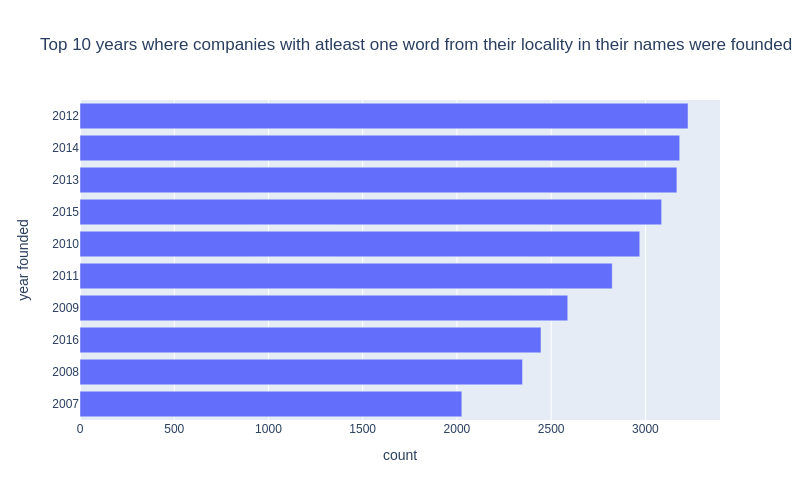

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with atleast one word from their locality in their names were founded')

### name and year founded

Here we will examine how many and which companies contain words from their respective years they were founded in their names.

In [ ]:
def year_in_name(row):
    if (row['year founded'] == 0):
        return None
    year = row['year founded']
    regexp = re.compile(f'{year}')
    return regexp.search(row['name'])

df['year_in_name'] = df.apply(year_in_name, axis=1).astype('bool').astype('int16')

In [ ]:
name_year_df = df[df['year_in_name'] > 0]
name_year_df

name  \
31275                                  ajb bumiputera 1912   
45093    peapack-gladstone bank private banking since 1921   
68174               the car finance company (2007) limited   
70562                                          fabbri 1905   
72341                                          altrak 1978   
...                                                    ...   
7102881    centre de formation automobile du québec (1991)   
7114170                                           gaia2001   
7117682                     gateway training services 2014   
7129743                              profab mécanique 2010   
7164167                   1984 personal management limited   

                                 domain  year founded  \
31275                    bumiputera.com          1912   
45093                        pgbank.com          1921   
68174        thecarfinancecompany.co.uk          2007   
70562                    fabbri1905.com          1905   
72341                  altrak1978.co.id          1978   
...                                 ...           ...   
7102881                     cfaq.quebec          1991   
7114170                     gaia2001.it          2001   
7117682  gatewaytrainingservices2014.ca          2014   
7129743                 descoprofab.com          2010   
7164167                      1984pm.com          1984   

                                 industry   size range  \
31275                           insurance  1001 - 5000   
45093                             banking   501 - 1000   
68174                  financial services    201 - 500   
70562                    food & beverages    201 - 500   
72341                           machinery    201 - 500   
...                                   ...          ...   
7102881  professional training & coaching       1 - 10   
7114170         marketing and advertising       1 - 10   
7117682           staffing and recruiting       1 - 10   
7129743                      construction       1 - 10   
7164167  professional training & coaching       1 - 10   

                                       locality         country  \
31275          jakarta, jakarta raya, indonesia       indonesia   
45093     bedminster, new jersey, united states   united states   
68174      hampshire, hampshire, united kingdom  united kingdom   
70562            bologna, emilia-romagna, italy           italy   
72341          jakarta, jakarta raya, indonesia       indonesia   
...                                         ...             ...   
7102881              blainville, quebec, canada          canada   
7114170           modena, emilia-romagna, italy           italy   
7117682               red deer, alberta, canada          canada   
7129743                 lachute, quebec, canada          canada   
7164167  london, greater london, united kingdom  united kingdom   

                                              linkedin url  \
31275             linkedin.com/company/ajb-bumiputera-1912   
45093          linkedin.com/company/peapack-gladstone-bank   
68174    linkedin.com/company/the-car-finance-company-2...   
70562                     linkedin.com/company/fabbri-1905   
72341                     linkedin.com/company/altrak-1978   
...                                                    ...   
7102881  linkedin.com/company/centredeformationautomobi...   
7114170                      linkedin.com/company/gaia2001   
7117682  linkedin.com/company/gateway-training-services...   
7129743         linkedin.com/company/profab-m-canique-2010   
7164167  linkedin.com/company/1984-personal-management-...   

         current employee estimate  total employee estimate  ...  \
31275                          374                      625  ...   
45093                          257                      435  ...   
68174                          167                      315  ...   
70562                          161                      349  ...   
72341                          157   

Let's explore these companies with respect to their country, size range, industry and year founded.

#### year_in_name and country

In [ ]:
country_df = name_year_df.groupby('country', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
country_df =  country_df.sort_values(by='count',ascending=False).reset_index(drop=True)
country_counts_df = df['country'].value_counts().rename_axis('country').reset_index(name='total_count')
country_df = country_df.merge(country_counts_df, left_on='country', right_on='country', how = 'left')
country_df['country'] = country_df['country'].astype('string').str.title()
country_df

country  count  total_count
0                  Italy    162        89516
1                  Spain    134       111862
2          United States    121      1657659
3                 Canada     89       146580
4         United Kingdom     63       335827
5            Netherlands     42       121598
6                Germany     22        92488
7                 Brazil     19        94612
8            New Zealand     18        16402
9                  India     16       120311
10                France     16        91381
11               Denmark     11        25917
12                Israel     11         6220
13                Sweden     11        30591
14                Greece     10         9616
15               Ireland      9        15981
16             Australia      8        96059
17               Hungary      8         5833
18              Bulgaria      7         5300
19               Belgium      7        31566
20           Switzerland      6        25424
21             Venezuela      6         3317
22                Norway      5        20709
23              Portugal      5        18014
24                Mexico      5        29077
25               Romania      5         9057
26             Indonesia      4        11725
27                 China      4        29696
28              Thailand      4         4515
29                Turkey      4        31654
30                Poland      4        18916
31               Finland      3        14717
32          South Africa      3        22736
33              Pakistan      2         8933
34               Georgia      2         1092
35                  Peru      1         8822
36              Tanzania      1          936
37             Palestine      1          370
38                Taiwan      1         2800
39  United Arab Emirates      1        18424
40                Serbia      1         3989
41               Albania      1          675
42               Morocco      1         3432
43             Mauritius      1          513
44               Austria      1         8769
45            Azerbaijan      1         1045
46                 Chile      1        17294
47              Colombia      1        15266
48            Costa Rica      1         2700
49               Croatia      1         4222
50                 Egypt      1         7259
51             Hong Kong      1         6579
52                 Japan      1         6763
53                Kuwait      1         1225
54             Argentina      1        21579
55             Lithuania      1         3718
56             Macedonia      1          878
57              Malaysia      1         8286
58                 Malta      1          979
59               Lebanon      1         2853

In [ ]:
# merge country_df and gdf
merged = gdf.merge(country_df, left_on='country', right_on='country', how = 'left')
merged.head()

country                                           geometry  count  \
0           Fiji  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...    NaN   
1       Tanzania  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...    1.0   
2      W. Sahara  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...    NaN   
3         Canada  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   89.0   
4  United States  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  121.0   

   total_count  
0         <NA>  
1          936  
2         <NA>  
3       146580  
4      1657659

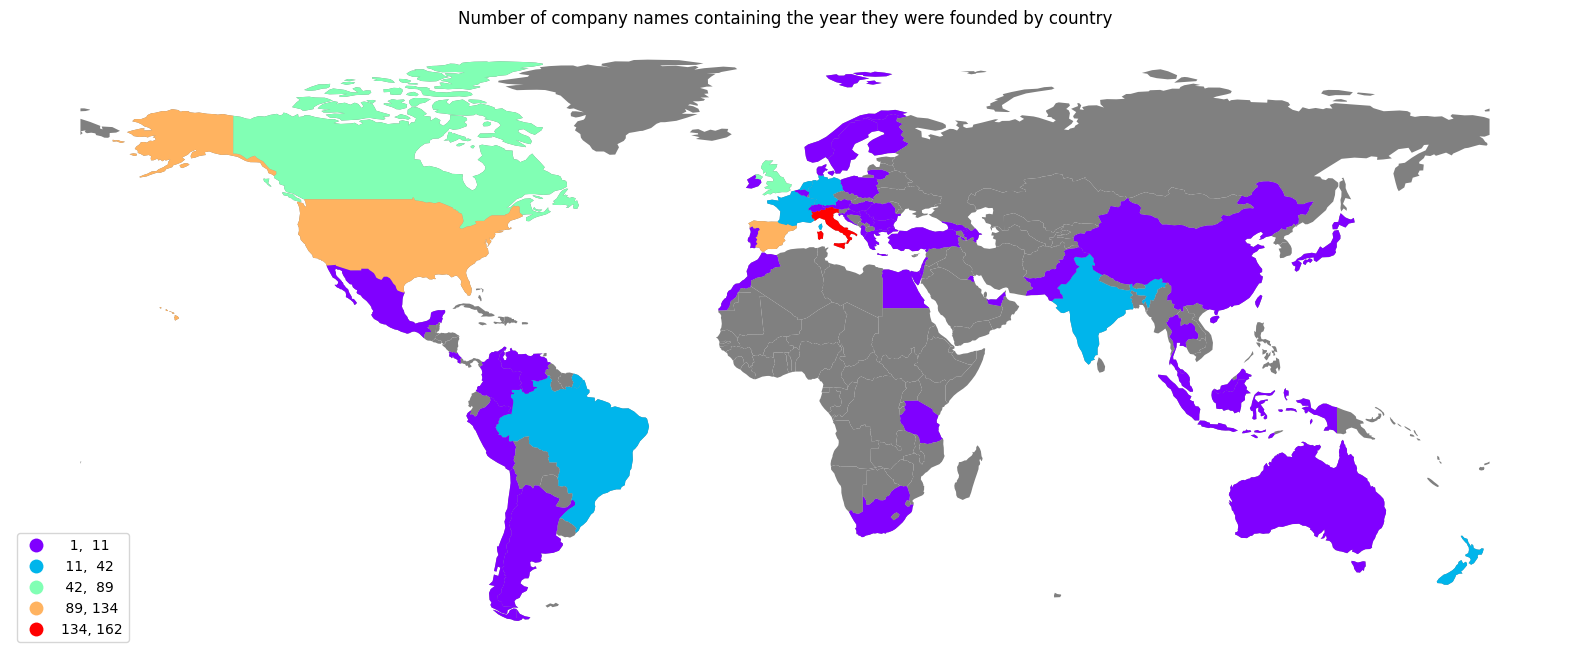

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,15))

merged.plot(color='grey', ax=ax, label = 'No data')
merged.dropna().plot(column='count', cmap='rainbow', ax=ax, scheme='natural_breaks', k=5, legend=True, legend_kwds={'loc': 'lower left'})

plt.title('Number of company names containing the year they were founded by country')

#fixing floating-point counts, making them integer:
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_text(text.get_text().replace('.00', ''))

plt.axis('off');

#### year_in_name and size range

Let us check if these names are related to size range.

In [ ]:
size_df = name_year_df.groupby('size range', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
size_counts_df = df['size range'].value_counts().rename_axis('size range').reset_index(name='total_count')
size_df = size_df.merge(size_counts_df, left_on='size range', right_on='size range', how = 'left')
size_df =  size_df.sort_values(by='count',ascending=False).reset_index(drop=True)
size_df

size range  count  total_count
0       1 - 10    574      2652155
1      11 - 50    224       692311
2     51 - 200     58       204469
3    201 - 500     13        46999
4  1001 - 5000      1        13937
5   501 - 1000      1        16416

As we can see from the result above, if a company's name contains the year it was founded the company tends to have a small number of employees. Again this also aligns with the general distibution of size range. So I don't think there is a special connection here.

#### year_in_name and industry

Let us check if these names are related to which industry.

In [ ]:
industry_df = name_year_df.groupby('industry', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
industry_counts_df = df['industry'].value_counts().rename_axis('industry').reset_index(name='total_count')
industry_df = industry_df.merge(industry_counts_df, left_on='industry', right_on='industry', how = 'left')
industry_df =  industry_df.sort_values(by='count',ascending=False).reset_index(drop=True)
industry_df

industry  count  total_count
0                           construction     43       143285
1                                 sports     39        32675
2                       food & beverages     30        49737
3              marketing and advertising     30       185119
4    information technology and services     27       241878
..                                   ...    ...          ...
112                   mental health care      1        15310
113                             military      1         1596
114             motion pictures and film      1        11804
115             packaging and containers      1         9248
116                       graphic design      1        22378

[117 rows x 3 columns]

In [ ]:
industry_df.head(10)

industry  count  total_count
0                         construction     43       143285
1                               sports     39        32675
2                     food & beverages     30        49737
3            marketing and advertising     30       185119
4  information technology and services     27       241878
5                    apparel & fashion     24        32869
6                               retail     23        62548
7               luxury goods & jewelry     20         8534
8                          real estate     20       105494
9                            furniture     19        18095

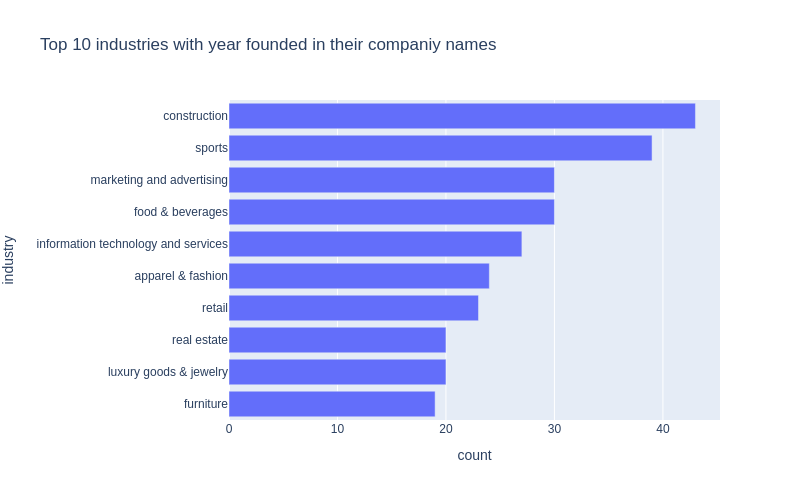

In [ ]:
plotly_plot_bar(industry_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='industry', title='Top 10 industries with year founded in their companiy names')

The bar chart plotted above shows top 10 industries with year founded in their companiy names. I think that it is obvious that sport companies are very associated with the year they were founded. The table above also proves this. Even though the sports industry has smaller number of companies in the dataset when compared to with the other industries ranking from 2-10, it is ranked as number 1 in the number of companiy names containing the year they were founded.

#### year_in_name and year founded

In [ ]:
year_df = name_year_df.groupby('year founded', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'count'})
year_counts_df = df['year founded'].value_counts().rename_axis('year founded').reset_index(name='total_count')
year_df = year_df.merge(year_counts_df, left_on='year founded', right_on='year founded', how = 'left')
year_df =  year_df.sort_values(by='count',ascending=False).reset_index(drop=True)
year_df['year founded'] = year_df['year founded'].astype('string')
year_df

year founded  count  total_count
0           2000     82        48181
1           2010     29       131784
2           2015     26       141830
3           2012     23       136035
4           2007     20        80997
..           ...    ...          ...
160         1808      1           37
161         1869      1          266
162         1866      1          257
163         1864      1          227
164         1805      1           39

[165 rows x 3 columns]

In [ ]:
year_df.head(10)

year founded  count  total_count
0         2000     82        48181
1         2010     29       131784
2         2015     26       141830
3         2012     23       136035
4         2007     20        80997
5         2014     20       143899
6         2016     19       123636
7         1999     18        42975
8         2001     17        48836
9         2006     17        71566

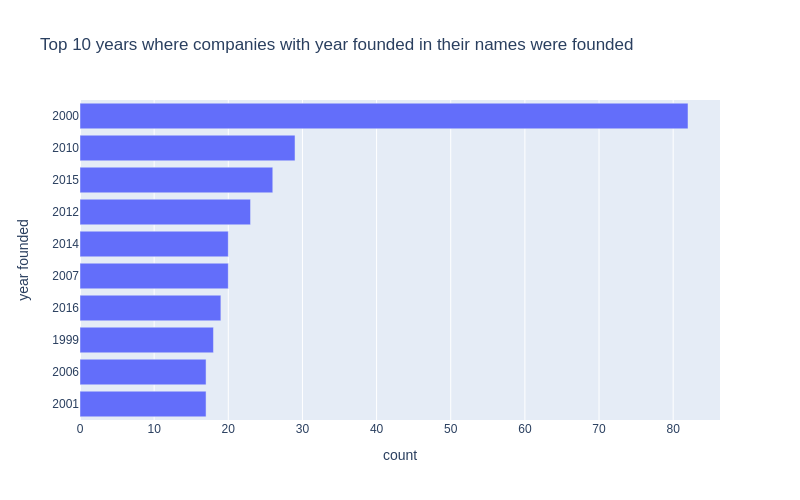

In [ ]:
plotly_plot_bar(year_df.nlargest(10, 'count').sort_values(by='count'), x='count', y='year founded', title='Top 10 years where companies with year founded in their names were founded')

Even though the number of companies founded in 2000 in the dataset are relatively smaller, it is ranked as number 1 in the number of company names containing the year they were founded. I think this is because the year 2000 is special as it is the start of a millenium, a year that comes once in a thousand years.

## Filtering Data and Answering Business Questions

### How many and which company names contain stop words?

In [ ]:
def stopword_in_name(name):
    # split words in name and replace the & symbol with 'and'
    name_words = re.split(r'\s|-',re.sub('&', ' and ', name))
    return len([i for i in name_words if i in STOPWORDS])
df['stopword_in_name_count'] = df['name'].apply(stopword_in_name)

In [ ]:
stopword_df = df[df['stopword_in_name_count'] > 0]
stopword_df

name              domain  year founded  \
9                                      at&t             att.com          1876   
17                     jpmorgan chase & co.   jpmorganchase.com          1823   
38           department of veterans affairs              va.gov          1930   
63                           the home depot       homedepot.com          1977   
136             nyc department of education             nyc.gov             0   
...                                     ...                 ...           ...   
7173376                    the hunter press  thehunterpress.com          1997   
7173380       exchange bank of northeast mo          ebnemo.com             0   
7173390                 curl up & dye salon     curlupsalon.com             0   
7173397      stone center for yoga & health       stoneyoga.com             0   
7173411  fuller, hadeed, & ros-planas, pllc          fhrlaw.com          2015   

                             industry size range  \
9                  telecommunications     10001+   
17                 financial services     10001+   
38          government administration     10001+   
63                             retail     10001+   
136              education management     10001+   
...                               ...        ...   
7173376                    publishing     1 - 10   
7173380                       banking     1 - 10   
7173390                     cosmetics     1 - 10   
7173397  health, wellness and fitness     1 - 10   
7173411                  law practice     1 - 10   

                                                locality        country  \
9                           dallas, texas, united states  united states   
17                     new york, new york, united states  united states   
38       washington, district of columbia, united states  united states   
63                       atlanta, georgia, united states  united states   
136                    new york, new york, united states  united states   
...                                                  ...            ...   
7173376         santa barbara, california, united states  united states   
7173380              queen city, missouri, united states  united states   
7173390                    hamilton, ohio, united states  united states   
7173397               teaneck, new jersey, united states  united states   
7173411          virginia beach, virginia, united states  united states   

                                              linkedin url  \
9                                linkedin.com/company/at&t   
17                     linkedin.com/company/jpmorgan-chase   
38       linkedin.com/company/department-of-veterans-af...   
63                     linkedin.com/company/the-home-depot   
136       linkedin.com/company/nyc-department-of-education   
...                                                    ...   
7173376              linkedin.com/company/the-hunter-press   
7173380  linkedin.com/company/exchange-bank-of-northeas...   
7173390           linkedin.com/company/curl-up-&-dye-salon   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173411                        linkedin.com/company/fhrlaw   

         current employee estimate  total employee estimate  ...  \
9                           115188                   269659  ...   
17                           95234                   242135  ...   
38                           62685                    86489  ...   
63                           44630                   114799  ...   
136                          30526                    45049  ...   
...                            ...                      ...  ...   
7173376                          0                        1  ...   
7173380                          0                        1  ...   
7173390                          0                        1  ...   
7173397                          0                        2  ...   
7173411                          0             

There are more than 930,000 companies whose names contain atleast one stop word.

### How many and which company names contain punctuations?

In [ ]:
punc_df = df[df['name_punc_count'] > 0]
punc_df

name                domain  \
9                                      at&t               att.com   
17                     jpmorgan chase & co.     jpmorganchase.com   
30                   mcdonald's corporation    aboutmcdonalds.com   
93                                  l'oréal            loreal.com   
151                   the coca-cola company  coca-colacompany.com   
...                                     ...                   ...   
7173397      stone center for yoga & health         stoneyoga.com   
7173402                      woonartikel.nl        woonartikel.nl   
7173404                   squad sp. z o. o.          squad.com.pl   
7173411  fuller, hadeed, & ros-planas, pllc            fhrlaw.com   
7173416                     fit plus s.r.o.            fitplus.sk   

         year founded                      industry size range  \
9                1876            telecommunications     10001+   
17               1823            financial services     10001+   
30               1955                   restaurants     10001+   
93                  0                     cosmetics     10001+   
151              1892              food & beverages     10001+   
...               ...                           ...        ...   
7173397             0  health, wellness and fitness     1 - 10   
7173402          2015                  online media     1 - 10   
7173404          2013                      internet     1 - 10   
7173411          2015                  law practice     1 - 10   
7173416          1993  health, wellness and fitness     1 - 10   

                                        locality        country  \
9                   dallas, texas, united states  united states   
17             new york, new york, united states  united states   
30            oak brook, illinois, united states  united states   
93                  paris, île-de-france, france         france   
151              atlanta, georgia, united states  united states   
...                                          ...            ...   
7173397       teaneck, new jersey, united states  united states   
7173402       giethoorn, overijssel, netherlands    netherlands   
7173404           litzmannstadt, lodzkie, poland         poland   
7173411  virginia beach, virginia, united states  united states   
7173416       bratislava, bratislavský, slovakia       slovakia   

                                              linkedin url  \
9                                linkedin.com/company/at&t   
17                     linkedin.com/company/jpmorgan-chase   
30             linkedin.com/company/mcdonald's-corporation   
93                             linkedin.com/company/loreal   
151             linkedin.com/company/the-coca-cola-company   
...                                                    ...   
7173397  linkedin.com/company/stone-center-for-yoga-&-h...   
7173402                linkedin.com/company/woonartikel.nl   
7173404             linkedin.com/company/squad-sp.-z-o.-o.   
7173411                        linkedin.com/company/fhrlaw   
7173416               linkedin.com/company/fit-plus-s.r.o.   

         current employee estimate  total employee estimate  ...  \
9                           115188                   269659  ...   
17                           95234                   242135  ...   
30                           68233                   235199  ...   
93                           37319                   107296  ...   
151                          29278                    77857  ...   
...                            ...                      ...  ...   
7173397                          0                        2  ...   
7173402                          0                        1  ...   
7173404                          0                        1  ...   
7173411                          0                        2  ...   
7173416                          0                        1  ...   

        name_word_count  name_word_density  name_p

There are more than 1,700,000 companies whose names contain atleast one punctuation mark.

### Which words are the most common in company names of each industry?

In [ ]:
industries = list(df['industry'].unique())
industry_name_words_dict = {}
for industry in industries:
    industry_df = df[df['industry'] == f'{industry}']
    text = " ".join(name for name in industry_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    industry_name_words_dict[f'{industry}'] = common_words

In [ ]:
def append_list(a,b):
    return a + b
all_words = reduce(append_list, list(industry_name_words_dict.values()))

In [ ]:
# select common words found in atleast 20 industries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (industry, words) in industry_name_words_dict.items():
    industry_name_words_dict[industry] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific industry as follows.

In [ ]:
industry_name_words_dict['financial services']

['financial',
 'capital',
 'wealth',
 'finance',
 'mortgage',
 'credit',
 'advisors',
 'investment',
 'union',
 'asset',
 'planning',
 'advisory',
 'management,',
 'funding',
 'advisors,',
 'bank',
 'securities',
 'first',
 'investments',
 'private',
 'lending',
 'federal',
 'llp']

In [ ]:
def search_industry(word):
    industries_list = []
    for (industry, words) in industry_name_words_dict.items():
        if word in words:
            industries_list.append(industry)
    return industries_list

To search for a word if it is in the list of most common word for industries we can use the function search_industry as shown below.

In [ ]:
search_industry('communication')

['telecommunications',
 'wireless',
 'public relations and communications',
 'marketing and advertising',
 'graphic design',
 'translation and localization']

### Which words are the most common in company names of each country?

In [ ]:
countries = list(df['country'].unique())
country_name_words_dict = {}
for country in countries:
    country_df = df[df['country'] == f'{country}']
    text = " ".join(name for name in country_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    country_name_words_dict[f'{country}'] = common_words

In [ ]:
all_words = reduce(append_list, list(country_name_words_dict.values()))

In [ ]:
# select common words found in atleast 20 countries
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 20]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (country, words) in country_name_words_dict.items():
    country_name_words_dict[country] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific country as follows.

In [ ]:
country_name_words_dict['netherlands']

['b.v.',
 'bv',
 'van',
 'stichting',
 'nederland',
 'advies',
 'voor',
 'groep',
 'amsterdam',
 'communicatie',
 'het',
 'advocaten',
 'der',
 'coaching',
 'online',
 'europe',
 'ict',
 'holland',
 'bureau',
 'dutch',
 'events',
 'support']

In [ ]:
def search_country(word):
    countries_list = []
    for (country, words) in country_name_words_dict.items():
        if word in words:
            countries_list.append(country)
    return countries_list

To search for a word if it is in the list of most common word for countries we can use the function search_country as shown below.

In [ ]:
search_country('communication')

['switzerland',
 'france',
 'sweden',
 'italy',
 'belgium',
 'luxembourg',
 'morocco',
 'bangladesh',
 'algeria',
 'tunisia',
 'hungary',
 'senegal',
 'benin',
 'democratic republic of the congo',
 'gabon',
 'martinique',
 'u.s. virgin islands']

### Which words are the most common in company names of each size range?

In [ ]:
size_ranges = list(df['size range'].unique())
size_range_name_words_dict = {}
for size_range in size_ranges:
    size_range_df = df[df['size range'] == f'{size_range}']
    text = " ".join(name for name in size_range_df.name)
    word_list = list(filter(lambda x: x!= '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    size_range_name_words_dict[f'{size_range}'] = common_words

In [ ]:
all_words = reduce(append_list, list(size_range_name_words_dict.values()))

In [ ]:
# select common words found in atleast 3 size ranges
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 2]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (size_range, words) in size_range_name_words_dict.items():
    size_range_name_words_dict[size_range] = [word for word in words if word not in words_to_be_removed]

Let's look at common words in company names for each size range.

In [ ]:
size_range_name_words_dict

{'10001+': ['department',
  'us',
  'air',
  'hotels',
  'south',
  'airways',
  'world',
  'canada',
  'life',
  'banco',
  'care',
  'education',
  'british',
  'financial',
  'texas',
  'florida'],
 '5001 - 10000': ['financial',
  'life',
  'department',
  'industries',
  'plc',
  'western',
  'texas'],
 '1001 - 5000': ['council', 'trust', 'nhs', 'la'],
 '501 - 1000': ['grupo', 'trust', 'care', 'foundation'],
 '201 - 500': ['grupo'],
 '51 - 200': ['spa', 'partners', 'co.,', 'ag', 'association', 'sa'],
 '11 - 50': ['srl',
  'design',
  'marketing',
  'partners',
  'capital',
  'associates',
  'association',
  'digital',
  'b.v.',
  'agency',
  'ag'],
 '1 - 10': ['design',
  'marketing',
  'studio',
  'law',
  'co',
  'associates',
  'construction',
  'digital',
  'capital',
  'creative',
  'srl',
  'club',
  'home',
  'service']}

In [ ]:
def search_size_range(word):
    size_ranges_list = []
    for (size_range, words) in size_range_name_words_dict.items():
        if word in words:
            size_ranges_list.append(size_range)
    return size_ranges_list

To search for a word if it is in the list of most common word for size_ranges we can use the function search_size_range as shown below.

In [ ]:
search_size_range('hotel')

[]

### Which words are the most common in company names founded during each decade after 1800?

In [ ]:
df['decade'] = df['year founded'].apply(lambda x: f'{(x//10)*10}s')

Here we will considers companies with valid value for the column year founded.

In [ ]:
from collections import Counter

decades = list(df['decade'].unique())

# Check if '0s' is in the list before removing it
if '0s' in decades:
    decades.remove('0s')

decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    words = " ".join(decade_df['name']).lower().split()
    decade_name_words_dict[decade] = Counter(words)

In [ ]:
import re
import collections

# Your existing code here...

decades = list(df['decade'].unique())

# Check if '0s' is in the list before attempting to remove it
if '0s' in decades:
    decades.remove('0s')

decade_name_words_dict = {}
for decade in decades:
    decade_df = df[df['decade'] == f'{decade}']
    text = " ".join(name for name in decade_df.name)
    word_list = list(filter(lambda x: x != '', re.split(r'\s|-', text)))
    common_words = [pair[0] for pair in collections.Counter(word_list).most_common(50)]
    decade_name_words_dict[f'{decade}'] = common_words


In [ ]:
all_words = reduce(append_list, list(decade_name_words_dict.values()))

In [ ]:
# select common words found in atleast 10 decades
common_words = [pair[0] for pair in dict(collections.Counter(all_words)).items() if pair[1] > 10]
words_to_be_removed = common_words + re.split(r'',string.punctuation) + list(STOPWORDS)

In [ ]:
for (decade, words) in decade_name_words_dict.items():
    decade_name_words_dict[decade] = [word for word in words if word not in words_to_be_removed]

We can look at common words in company names from a specific decade as follows.

In [ ]:
decade_name_words_dict['2000s']

['solutions',
 'consulting',
 'design',
 'media',
 'management',
 'marketing',
 'technologies',
 'technology',
 'business',
 'systems',
 'e',
 'studio',
 'srl',
 'global',
 'capital',
 'partners',
 'digital',
 'creative',
 'group,',
 'software',
 'law',
 'associates',
 'ab',
 'pty',
 'communications',
 'engineering',
 'pvt.',
 'financial',
 'web']

In [ ]:
def search_decade(word):
    decades_list = []
    for (decade, words) in decade_name_words_dict.items():
        if word in words:
            decades_list.append(decade)
    return decades_list

To search for a word if it is in the list of most common word for decades we can use the function search_decade as shown below.

In [ ]:
search_decade('software')

['1980s', '2000s', '1990s', '2010s']

## Conclusions of EDA

* The most common words are related to company structure like pvt, ltd, limited, llc, co, inc, group, and gmbh.
* Country and industry names are also frequent.
* Even though they are not frequent companies use single characters like s, b and v in their names. I assume that these characters are abbreviations and are mmostly followed by a peried(.).
* The most common industry is 'infomation technoogy and services'.
* More than 93% of the companies have employees less than or equal to 50.
* Most companies are found in the biggest cities of the developed world like london, new york, madrid and paris.
* On average chinese companies have many characters and words in their names when compared to other countries.
* On average the countries 'Czechia', 'Slovenia', 'Slovakia', 'China', 'Croatia', 'Venezuela', 'Thailand', 'Taiwan', and 'Bosnia And Herzegovina' have the highest number of punctuation marks in their company names.
* On average the countries 'Taiwan', 'Guadeloupe', 'South Korea', 'Venezuela', 'Albania', and 'Curaçao' have the highest number of digits in their company names.
* 'Belarus', 'Russia', 'Turkey', 'Iran', and 'Kazakhstan' are the countries with the highest number of non-aschii characters in their company names on average.
* 'United States', 'United Kingdom', 'Canada', 'India', and 'Australia' are top 5 countries with the highest number of companies with names containing atleast one word from their respective industry.
* 'marketing and advertising',  'management consulting', 'construction', 'hospital & health care', and 'information technology and services' are top 5 industries with the highest number of companies with names containing atleast one word from their respective industry.
* '2010', '2014', '2013', '2015', and '2012' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective industry were founded.
* 'United States', 'India', 'Australia', 'Canada', and 'France' are top 5 countries with the highest number of companies with names containing atleast one word from their respective locality.
* 'information technology and services', 'non-profit organization management', 'education management', 'hospital & health care', and 'marketing and advertising' are top 5 industries with the highest number of companies with names containing atleast one word from their respective locality.
* '2012', '2014', '2013', '2015', and '2010' are top 5 years  when with the highest number of companies with names containing atleast one word from their respective locality were founded.
* 'sports',  'construction', 'information technology and services', 'marketing and advertising', and 'retail' are top 5 industries with the highest number of companies with names containing the year they were founded.
* '2000', '2010', '2016', '2014', and '2015' are top 5 years  when with the highest number of companies with names containing the year they were founded.